Выполняем импорт необходимых библиотек

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 10.6 MB/s eta 0:00:00


In [2]:
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=831162 sha256=62a13b7adc4032f9e0fbcd5596c4f48c36787606e4420f8046d2f8facc2e542a
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built lightfm


In [3]:
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import tqdm

import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import random
import pickle
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k,auc_score

import warnings
warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Загрузим датасеты, которые планируется использовать в анализе (основной датасет, датасет исполнителей с указанием жанров их композиций и датасет с пользовательскими предпочтениями).

а) ***Основной датасет.*** В этом датасете содержатся характеристики отдельных композиций. Однако в нем отсутствует информация о жанрах композиций. Эту информацию мы возьмем из датасета с характеристиками жанров и датасета с характеристиками исполнителей.

In [1]:
import pandas as pd

In [3]:
main_data = pd.read_csv("HW/spotify_dataset/data/data.csv")
main_data.reset_index(inplace=True)
main_data.rename(columns={"index": "song_id"}, inplace=True)
main_data.head()

song_id  valence  year  acousticness  \
0        0   0.0594  1921         0.982   
1        1   0.9630  1921         0.732   
2        2   0.0394  1921         0.961   
3        3   0.1650  1921         0.967   
4        4   0.2530  1921         0.957   

                                             artists  danceability  \
0  ['Sergei Rachmaninoff', 'James Levine', 'Berli...         0.279   
1                                     ['Dennis Day']         0.819   
2  ['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...         0.328   
3                                   ['Frank Parker']         0.275   
4                                     ['Phil Regan']         0.418   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       831667   0.211         0  4BJqT0PrAfrxzMOxytFOIz          0.878000   
1       180533   0.341         0  7xPhfUan2yNtyFG0cUWkt8          0.000000   
2       500062   0.166         0  1o6I8BglA6ylDMrIELygv1          0.913000   
3       210000   0.309         0  3ftBPsC5vPBKxYSee08FDH          0.000028   
4       166693   0.193         0  4d6HGyGT8e121BsdKmw9v6          0.000002   

   key  liveness  loudness  mode  \
0   10     0.665   -20.096     1   
1    7     0.160   -12.441     1   
2    3     0.101   -14.850     1   
3    5     0.381    -9.316     1   
4    3     0.229   -10.096     1   

                                                name  popularity release_date  \
0  Piano Concerto No. 3 in D Minor, Op. 30: III. ...           4         1921   
1                            Clancy Lowered the Boom           5         1921   
2                                          Gati Bali           5         1921   
3                                          Danny Boy           3         1921   
4                        When Irish Eyes Are Smiling           2         1921   

   speechiness    tempo  
0       0.0366   80.954  
1       0.4150   60.936  
2       0.0339  110.339  
3       0.0354  100.109  
4       0.0380  101.665

b) ***Датасет с характеристиками исполнителей.*** Данный датасет содержит информацию об отдельных исполнителях, жанрах, к которым принадлежат их композиции, а также обобщенные характеристики композиций для этих исполнителей. В дальнейшем предполагается получить из этого датасета набор жанров, к которым принадлежат композиции соответствующего исполнителя, и, имея эту информацию, обратиться к датасету с характеристиками жанров (data_by_genres) и получить обобщенные характеристики композиций для этих жанров. Тем самым, мы будем иметь обобщенные характеристики композиций с учетом тех жанров, которые применимы к соответствующим исполнителям. Перенеся эти данные в основной датасет, мы получим характеристики композиций с учетом жанров и исполнителей. Предполагается, что такой подход улучшит кластеризацию и позволит осуществлять подбор композиций не только на основе характеристики самой композиции, но и с учетом жанровых характеристик.

In [ ]:
data_w_genres = pd.read_csv("HW/spotify_dataset/data/data_w_genres.csv")
data_w_genres.head()

genres                                            artists  \
0  ['show tunes']                   "Cats" 1981 Original London Cast   
1              []                          "Cats" 1983 Broadway Cast   
2              []        "Fiddler On The Roof” Motion Picture Chorus   
3              []     "Fiddler On The Roof” Motion Picture Orchestra   
4              []  "Joseph And The Amazing Technicolor Dreamcoat"...   

   acousticness  danceability    duration_ms    energy  instrumentalness  \
0      0.590111      0.467222  250318.555556  0.394003          0.011400   
1      0.862538      0.441731  287280.000000  0.406808          0.081158   
2      0.856571      0.348286  328920.000000  0.286571          0.024593   
3      0.884926      0.425074  262890.962963  0.245770          0.073587   
4      0.510714      0.467143  270436.142857  0.488286          0.009400   

   liveness   loudness  speechiness       tempo   valence  popularity  key  \
0  0.290833 -14.448000     0.210389  117.518111  0.389500   38.333333    5   
1  0.315215 -10.690000     0.176212  103.044154  0.268865   30.576923    5   
2  0.325786 -15.230714     0.118514   77.375857  0.354857   34.857143    0   
3  0.275481 -15.639370     0.123200   88.667630  0.372030   34.851852    0   
4  0.195000 -10.236714     0.098543  122.835857  0.482286   43.000000    5   

   mode  count  
0     1      9  
1     1     26  
2     1      7  
3     1     27  
4     1      7

c) ***Датасет с характеристиками жанров.*** Из этого датасета будут получены характеристики отдельных жанров, которые затем будут перенесены в датасет с характеристиками исполнителей (см. выше), который содержит характеристики исполнителей с перечислением их жанров.

In [ ]:
data_by_genres = pd.read_csv("HW/spotify_dataset/data/data_by_genres.csv")
data_by_genres.head()

mode                  genres  acousticness  danceability   duration_ms  \
0     1  21st century classical      0.979333      0.162883  1.602977e+05   
1     1                   432hz      0.494780      0.299333  1.048887e+06   
2     1                   8-bit      0.762000      0.712000  1.151770e+05   
3     1                      []      0.651417      0.529093  2.328809e+05   
4     1              a cappella      0.676557      0.538961  1.906285e+05   

     energy  instrumentalness  liveness   loudness  speechiness       tempo  \
0  0.071317          0.606834  0.361600 -31.514333     0.040567   75.336500   
1  0.450678          0.477762  0.131000 -16.854000     0.076817  120.285667   
2  0.818000          0.876000  0.126000  -9.180000     0.047000  133.444000   
3  0.419146          0.205309  0.218696 -12.288965     0.107872  112.857352   
4  0.316434          0.003003  0.172254 -12.479387     0.082851  112.110362   

    valence  popularity  key  
0  0.103783   27.833333    6  
1  0.221750   52.500000    5  
2  0.975000   48.000000    7  
3  0.513604   20.859882    7  
4  0.448249   45.820071    7

d) ***Датасет с пользовательскими предпочтениями.*** Этот датасет (users_preference_data) будет создан на основе основного датасета (main_data) с использованием приведенного ниже скрипта после завершения предварительной подготовки основного датасета. Датасет users_preference_data будет использован для обучения модели и формирования рекомендаций для отдельных пользователей.

In [8]:
users_dict = {
    'Дмитрий Навой': [17493,  17732, 50266, 50803, 52028, 66552, 66694, 67720, 67859, 82035,
        84920, 85985, 89997, 99515, 99731, 100004, 100355, 100417,  100621, 100751,
        100877, 101008, 101258, 101286,  124929, 124951, 125005, 149019, 149569, 152432],
    'Pavel': [70312, 27916, 147255, 8062, 9302, 26983, 147548, 132730, 67813, 10429, 30652,
        8517, 95461, 132175,145959, 120376, 12469, 16118, 132437, 34729, 16134, 10922,
        12240, 70500, 129707, 12519, 12549, 12418, 13812, 13822],
    'Anetta': [106794, 107005, 121901, 14704, 85028, 35573, 54325, 16877, 121675, 16612, 137053, 18020,
        19600, 16211, 16384, 151967, 13812, 15831, 53638, 16872, 18426, 89878, 104987, 87054, 106686,
        138705, 17054, 88507, 55998, 73894],
    'Татьяна Качан': [288, 298, 317, 619, 629, 887, 896, 900, 906, 910, 1233, 1240, 1274, 1280, 1716, 1719, 1756,
        1960, 4221, 4424, 4431, 4454, 8841, 8846, 8864, 8873, 9085, 9359, 9370, 9437],
    'Железный Дровосек': [3513, 15435, 15514, 33832, 36293, 73082, 85294, 85802, 85817, 86012, 86229, 88226, 88386,
         88584, 88785, 115424, 115430, 165599, 60412, 52454, 84725, 86699, 101964, 73261, 119531,
         120168, 120098, 132087, 169747, 12279],
    'Валерий Кузнецов': [56639, 56964, 154840, 170183, 16916, 17417, 17437, 17484, 37203, 55143,
                         55979, 122634, 124628, 153408, 17465, 18100, 37072, 153425, 169636, 37242,
                         18318, 37918, 37922, 74531, 124616, 140207, 170354, 17448, 17860, 90202],
    'Борис': [53043, 34466, 139385, 107422, 17809, 17830, 18134, 36742, 140391, 38493, 9417,
              56021, 12994, 19616, 55101, 17459, 37708, 32761, 31488, 18290, 12007, 68153,
              16668, 13448, 50689, 17836, 19020, 18689, 17807, 19045],
    'Yulia': [18247, 18391, 170386, 15895, 15717, 16284, 53356, 70390, 98318, 165886, 19586, 17271,
              18969, 73837, 9548, 37179, 74186, 74052, 74001, 18128, 18122, 18111, 18083, 18075,
              17987, 17920, 17880, 17672, 14796, 37276],
    '.': [15609, 15628, 14412, 15239, 15293, 15285, 15809, 16628, 17799, 36745, 16917, 16980, 108542,
          123719, 16054, 169623, 16615, 72214, 35381, 121357, 15630, 15633, 15473, 74617, 18440, 17025,
          18412, 19021, 18423, 17836],
    'Тимофей Цыкман': [16001, 54294, 11606, 73727, 16396, 15608, 16430, 34974, 121529, 72962, 55253, 17290,
                       106646, 12520, 15814, 17291, 15055, 15880, 122021, 9611, 167392, 152458, 9624, 17417,
                       18093, 13806, 120716, 36715, 91111, 11933],
    }

In [9]:
class UsersPreferences:
    def __init__(self, data, users_dict):
        self.data = data
        self.users_dict = users_dict
        self.users = self.users_dict.keys()
        self.users_preference_data = pd.DataFrame()

    def make_users_preference_df(self):

        for user_id, user in enumerate(self.users, 1):
            next_user_data = self.data.loc[self.users_dict[user]]
            next_user_data.insert(0, 'user_name', user)
            next_user_data.insert(0, 'user_ID', user_id)
            self.users_preference_data = pd.concat([self.users_preference_data, next_user_data])

        return self.users_preference_data

### **1. Предобработка исходных датасетов**
#### **1.1 Предобработка основного датасета main_data**

Основной датасет (main_data) не содержит пустых ячеек. Все ячейки, за исключением столбцов "artists" (исполнители), "name" (наименование композиции) и "release date" (дата релиза композиции), являются числовыми, что соответствует логике. При анализе мы не будем использовать столбец "release_date", а также столбец "id". Также удалим их. Кроме того, удалим столбцы с бинарными значениями 0 и 1 (это столбцы "explicit" и "mode"). В отношении сохранения или удаления иных столбцов определимся по результатам корреляционного анализа.

In [10]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   song_id           170653 non-null  int64  
 1   valence           170653 non-null  float64
 2   year              170653 non-null  int64  
 3   acousticness      170653 non-null  float64
 4   artists           170653 non-null  object 
 5   danceability      170653 non-null  float64
 6   duration_ms       170653 non-null  int64  
 7   energy            170653 non-null  float64
 8   explicit          170653 non-null  int64  
 9   id                170653 non-null  object 
 10  instrumentalness  170653 non-null  float64
 11  key               170653 non-null  int64  
 12  liveness          170653 non-null  float64
 13  loudness          170653 non-null  float64
 14  mode              170653 non-null  int64  
 15  name              170653 non-null  object 
 16  popularity        17

In [11]:
main_data.drop(["explicit", "mode", "id", "release_date"], axis=1, inplace=True)
main_data.columns

Index(['song_id', 'valence', 'year', 'acousticness', 'artists', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'name', 'popularity', 'speechiness', 'tempo'],
      dtype='object')

***Далее изучим числовые показатели.***

In [12]:
main_data.describe()

song_id        valence           year   acousticness  \
count  170653.000000  170653.000000  170653.000000  170653.000000   
mean    85326.000000       0.528587    1976.787241       0.502115   
std     49263.422081       0.263171      25.917853       0.376032   
min         0.000000       0.000000    1921.000000       0.000000   
25%     42663.000000       0.317000    1956.000000       0.102000   
50%     85326.000000       0.540000    1977.000000       0.516000   
75%    127989.000000       0.747000    1999.000000       0.893000   
max    170652.000000       1.000000    2020.000000       0.996000   

        danceability   duration_ms         energy  instrumentalness  \
count  170653.000000  1.706530e+05  170653.000000     170653.000000   
mean        0.537396  2.309483e+05       0.482389          0.167010   
std         0.176138  1.261184e+05       0.267646          0.313475   
min         0.000000  5.108000e+03       0.000000          0.000000   
25%         0.415000  1.698270e+05       0.255000          0.000000   
50%         0.548000  2.074670e+05       0.471000          0.000216   
75%         0.668000  2.624000e+05       0.703000          0.102000   
max         0.988000  5.403500e+06       1.000000          1.000000   

                 key       liveness       loudness     popularity  \
count  170653.000000  170653.000000  170653.000000  170653.000000   
mean        5.199844       0.205839     -11.467990      31.431794   
std         3.515094       0.174805       5.697943      21.826615   
min         0.000000       0.000000     -60.000000       0.000000   
25%         2.000000       0.098800     -14.615000      11.000000   
50%         5.000000       0.136000     -10.580000      33.000000   
75%         8.000000       0.261000      -7.183000      48.000000   
max        11.000000       1.000000       3.855000     100.000000   

         speechiness          tempo  
count  170653.000000  170653.000000  
mean        0.098393     116.861590  
std         0.162740      30.708533  
min         0.000000       0.000000  
25%         0.034900      93.421000  
50%         0.045000     114.729000  
75%         0.075600     135.537000  
max         0.970000     243.507000

Прежде всего, отмечаем, что показатели "valence", "acousticness", "danceability", "energy	", "instrumentalness", "liveness", "speechiness" принимают значения от 0 до 1.Для признака "year" для снижения количества различных значений объединим года в десятилетия, т.е. округлим значения до ближайшего десятилетия, т.е. 1926 г. или 1932 г. -> 1930 г., а 2013 г. (или 2009 г.) -> 2010 г.

In [13]:
main_data.year = main_data.year.apply(lambda x: round(x, -1))
main_data.year = main_data.year.astype(int)
main_data.year.unique()

array([1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020])

In [14]:
numeric_features = ["year", "duration_ms", "valence", "acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", "popularity", "speechiness", "tempo", "key"]

Построим коробчатые диаграммы и гистограммы для числовых признаков.

In [15]:
def box_plot(data, features, n_rows=4, n_cols=4):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    for i, feature in enumerate(features):
        ax = axes[i // n_cols, i % n_cols]
        ax.boxplot(data[feature])
        ax.set_title(feature)

In [16]:
def hist_plot(data, features, n_rows=4, n_cols=4):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 15))
    for i, feature in enumerate(features):
        ax = axes[i // n_cols, i % n_cols]
        sns.histplot(x=data[feature], kde=True, ax=ax)

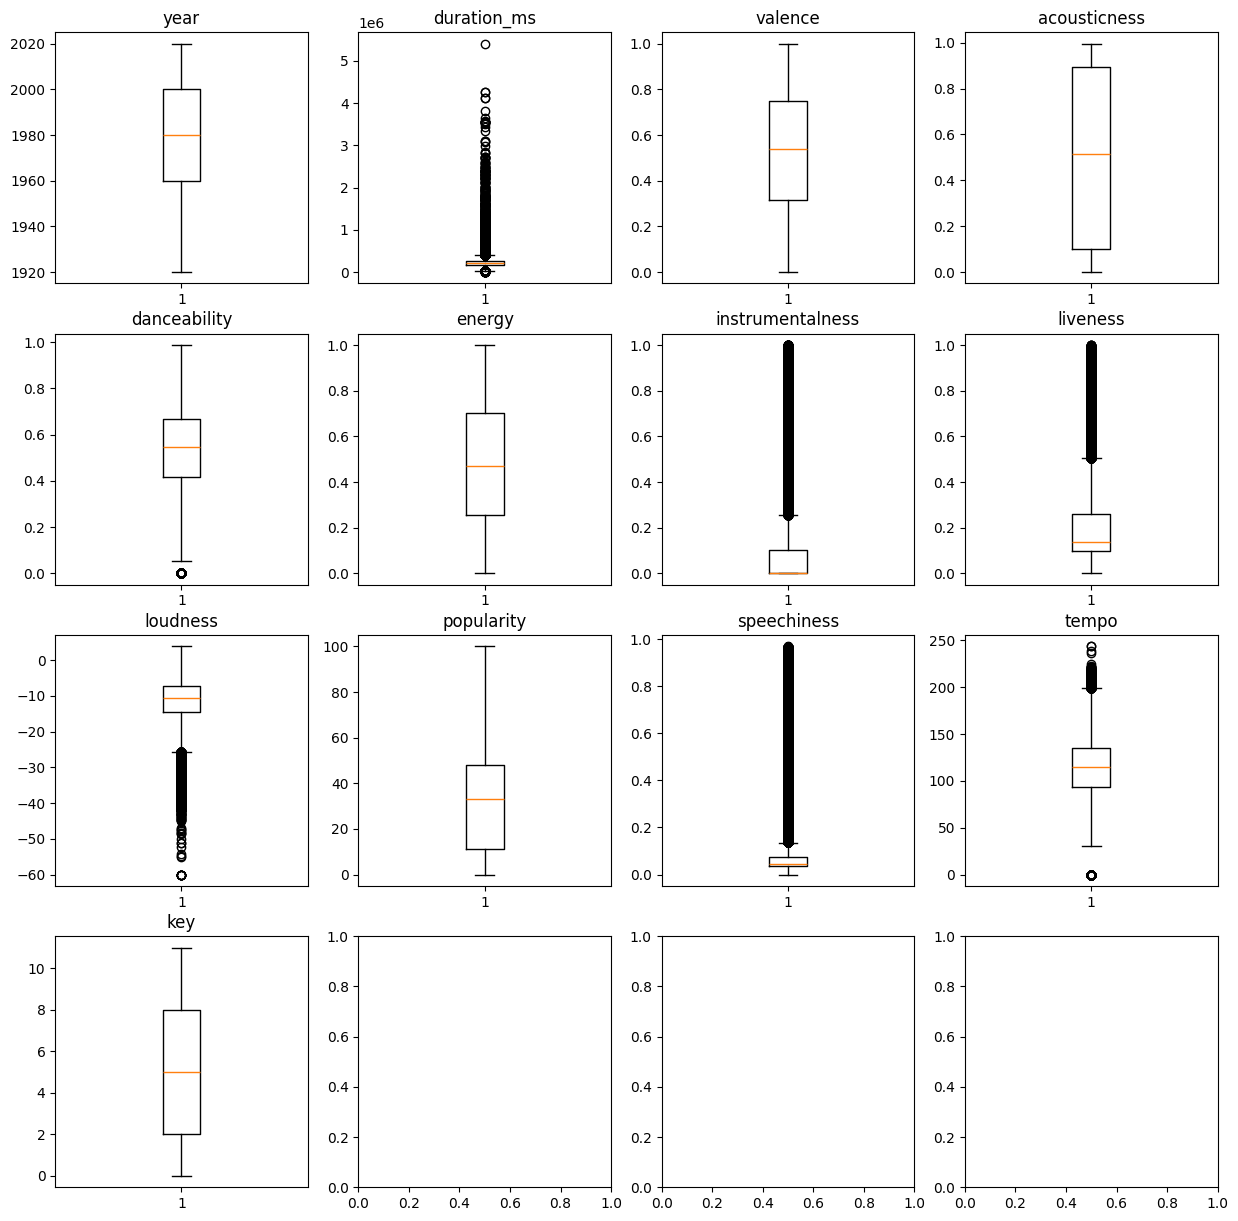

In [17]:
box_plot(main_data, numeric_features)

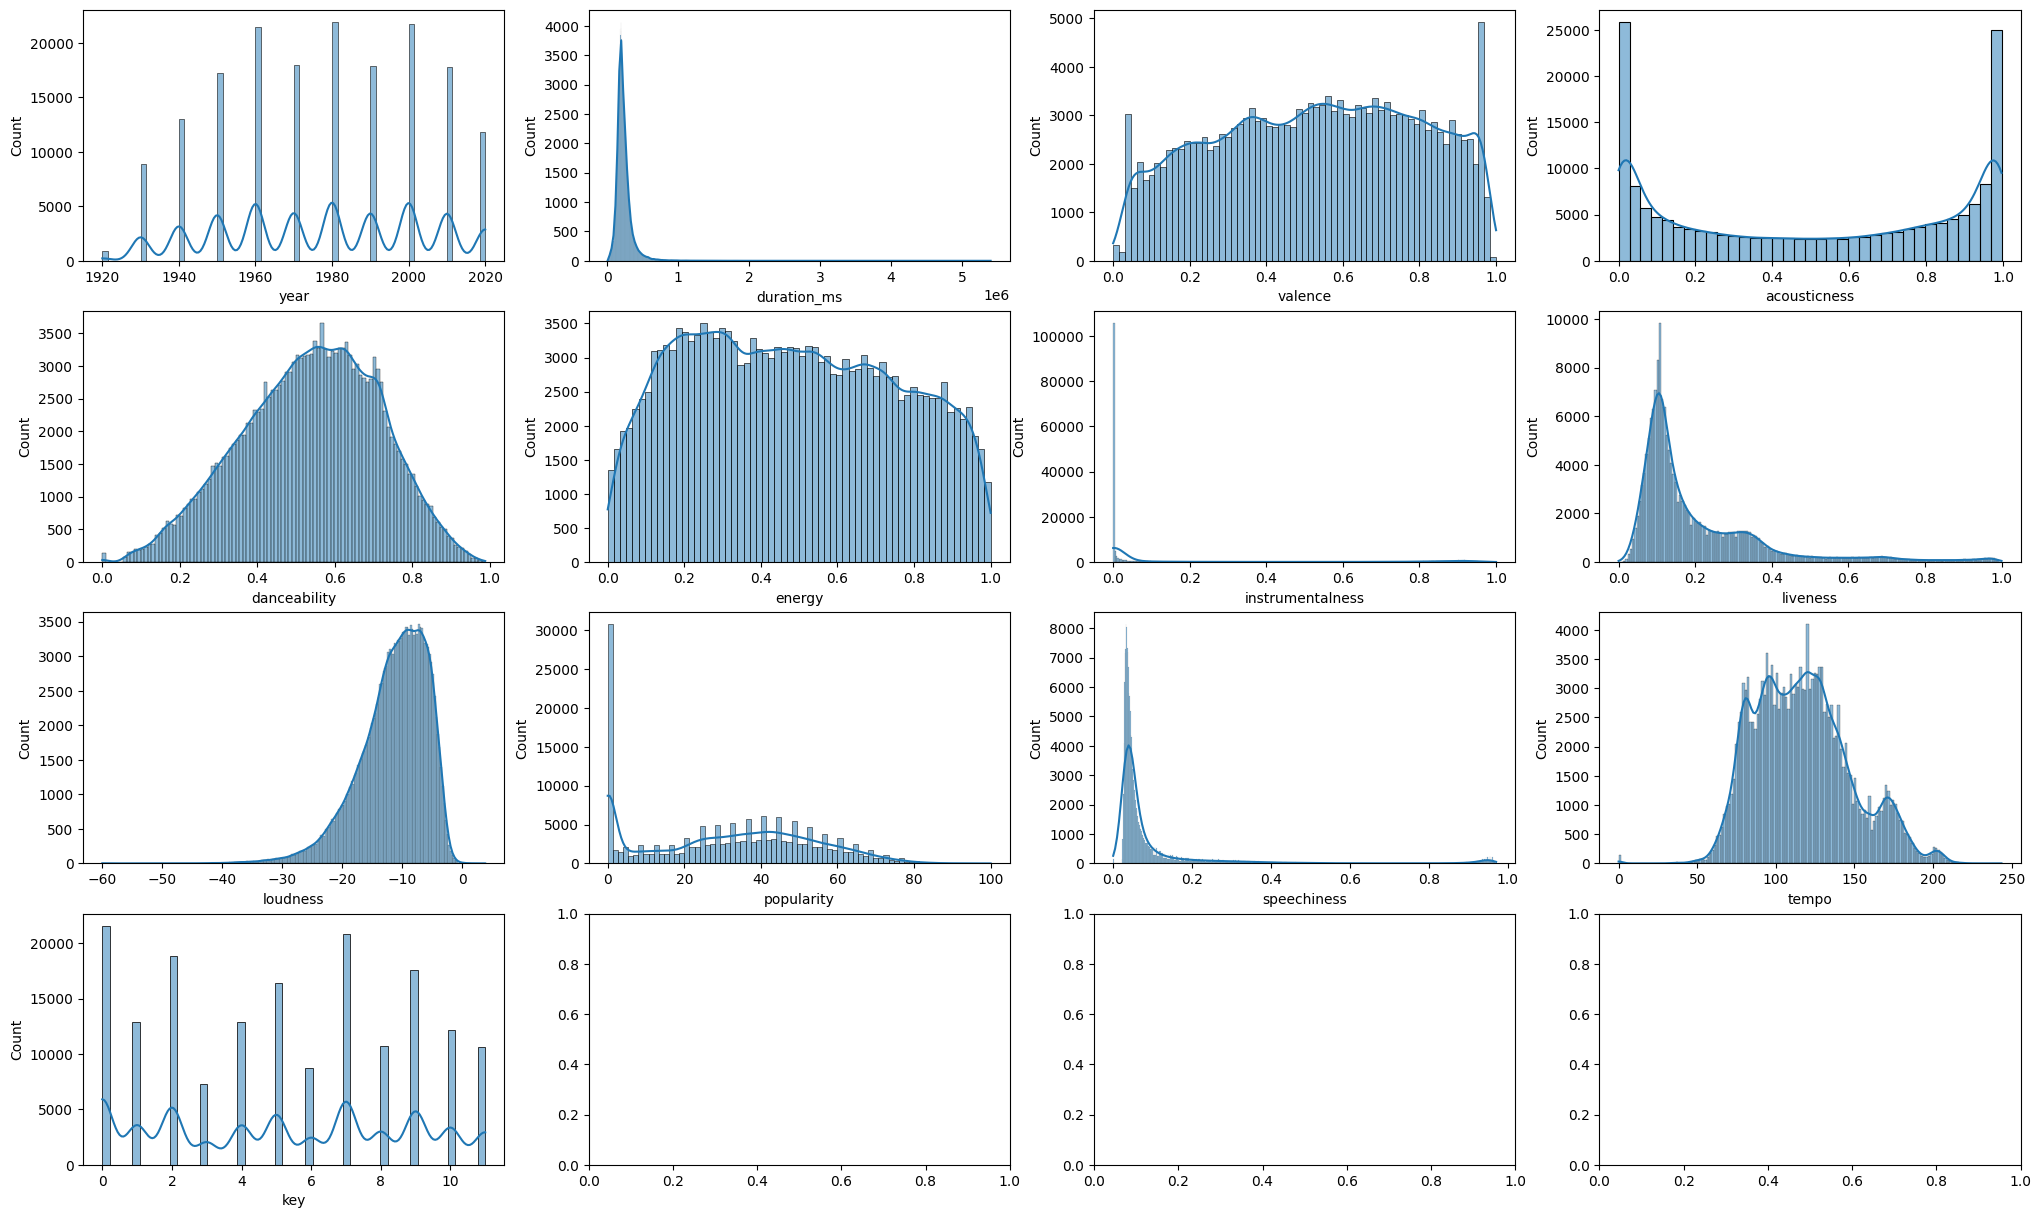

In [18]:
hist_plot(main_data, numeric_features)

Исходя из приведенных выше коробчатых диаграмм и гистограмм, делаем заключение о наличии выпадающих значений для показателей "duration_ms", "instrumentalness", "livenes", "loudness", "speechness", "tempo". Кроме того, отмечаем отсутствие нормального распределения для признаков, что свидетельствует о необходимости удаления выбросов и нормализации значений. Показатель "instrumentalness" в большинстве случаев принимает значения вблизи нуля либо нулевое значение. Мы не можем однозначно утверждать, что эти нулевые значения являются свидетельством отсутствия данных. Возможно, многим композициям присвоена именно нулевая оценка по данному показателю.

Подготовим корреляционную матрицу для числовых показателей

In [19]:
def corr_matrix(data, features):
  corr_matrix = data[features].corr()

  plt.figure(figsize=(12, 10))
  sns.heatmap(corr_matrix,
              annot=True,
              fmt=".2f",
              cmap='coolwarm',
              center=0,
              linewidths=0.5)
  plt.title("Корреляция характеристик", pad=20)
  plt.xticks(rotation=45)
  plt.yticks(rotation=0)
  plt.tight_layout()
  plt.show()

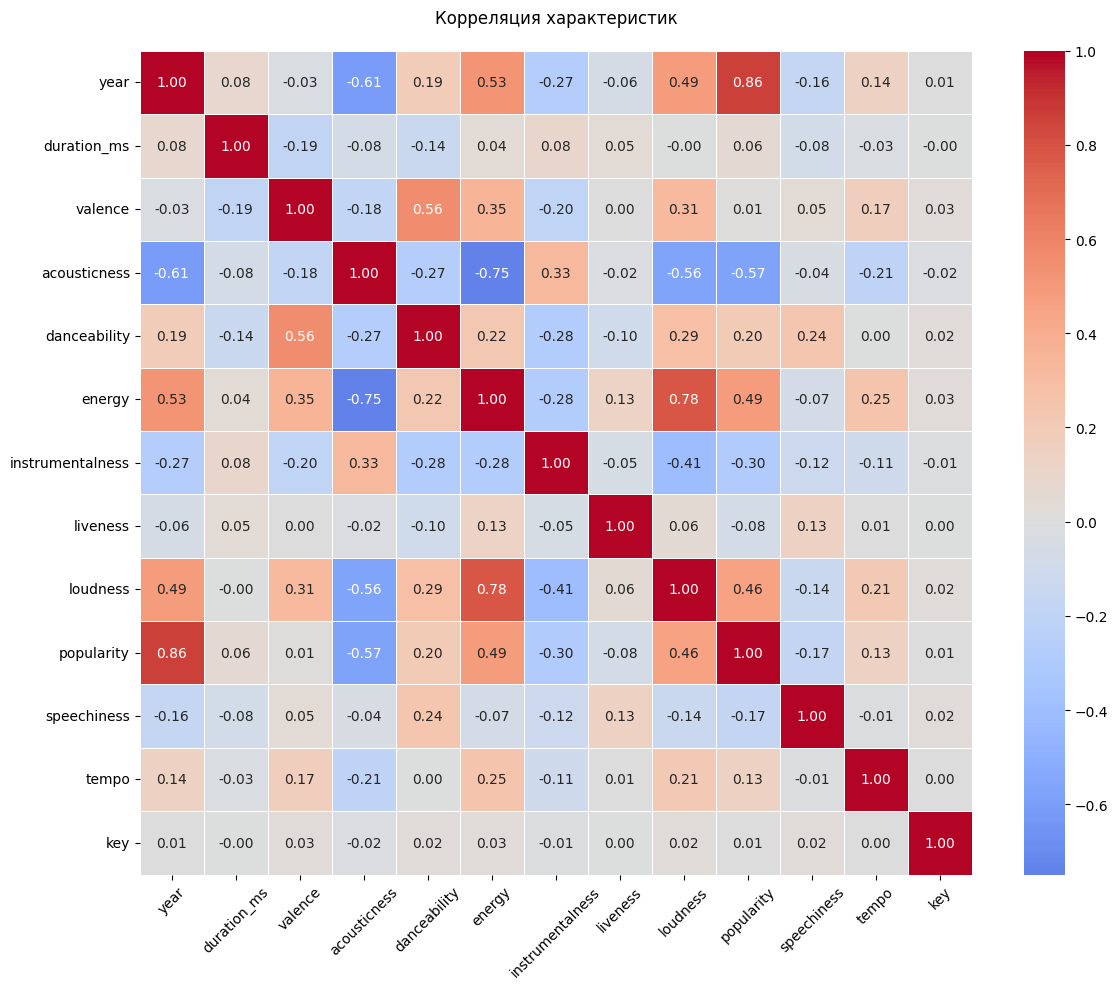

In [20]:
corr_matrix(main_data, numeric_features)

Отмечаем высокую корреляцию между показателями "popularity" и "year" (что объяснимо, поскольку оценки популярности определялись в настоящее время, поэтому композиции прошлых лет будут менее популярны, а современные композиции - более популярны), показателями "acousticness" и "year", "acousticness" и "energy", "acousticness" и "loudness", "acousticness" и "popularity", "danceability" и "valence", а также "loudness" и "energy". Для проверки наличия корреляции между показателями проведем статистический тест по Пирсону и Спирману.

In [21]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr

def check_correlation(data, features):
  for i, feature in enumerate(features):
    corr_pearson, p_value_pearson = pearsonr(data[feature[0]], data[feature[1]])
    corr_spearman, p_value_spearman = spearmanr(data[feature[0]], data[feature[1]])
    print(f"Коэфф. корреляции и р-значение для показателей {feature[0]} и {feature[1]} по Пирсону и Спирману: ({corr_pearson:.3f}, {p_value_pearson:.3f}) и ({corr_spearman:.3f}, {p_value_spearman:.3f})")


In [22]:
check_correlation(main_data, (["popularity", "year"],
                               ["acousticness", "energy"],
                                ["acousticness", "loudness"],
                                 ["acousticness", "popularity"],
                                  ["danceability", "valence"],
                                  ["loudness", "energy"]))

Коэфф. корреляции и р-значение для показателей popularity и year по Пирсону и Спирману: (0.859, 0.000) и (0.859, 0.000)
Коэфф. корреляции и р-значение для показателей acousticness и energy по Пирсону и Спирману: (-0.749, 0.000) и (-0.759, 0.000)
Коэфф. корреляции и р-значение для показателей acousticness и loudness по Пирсону и Спирману: (-0.562, 0.000) и (-0.600, 0.000)
Коэфф. корреляции и р-значение для показателей acousticness и popularity по Пирсону и Спирману: (-0.573, 0.000) и (-0.574, 0.000)
Коэфф. корреляции и р-значение для показателей danceability и valence по Пирсону и Спирману: (0.559, 0.000) и (0.540, 0.000)
Коэфф. корреляции и р-значение для показателей loudness и energy по Пирсону и Спирману: (0.782, 0.000) и (0.814, 0.000)


Исходя из приведенных выше значений, отмечаем, что для выбранных пар показателей наблюдается статистически значимая корреляция, подтвержденная теста Пирсона и Спирмана. Поэтому удалим один из пары коррелирующих показателей: "year", "acousticness", "energy", "danceability".

In [23]:
correlated_features = ["year", "acousticness", "energy", "danceability"]
main_data.drop(correlated_features, axis=1, inplace=True)
main_data.columns

Index(['song_id', 'valence', 'artists', 'duration_ms', 'instrumentalness',
       'key', 'liveness', 'loudness', 'name', 'popularity', 'speechiness',
       'tempo'],
      dtype='object')

In [24]:
selected_numeric_features = [feature for feature in numeric_features if feature not in correlated_features]
selected_numeric_features

['duration_ms',
 'valence',
 'instrumentalness',
 'liveness',
 'loudness',
 'popularity',
 'speechiness',
 'tempo',
 'key']

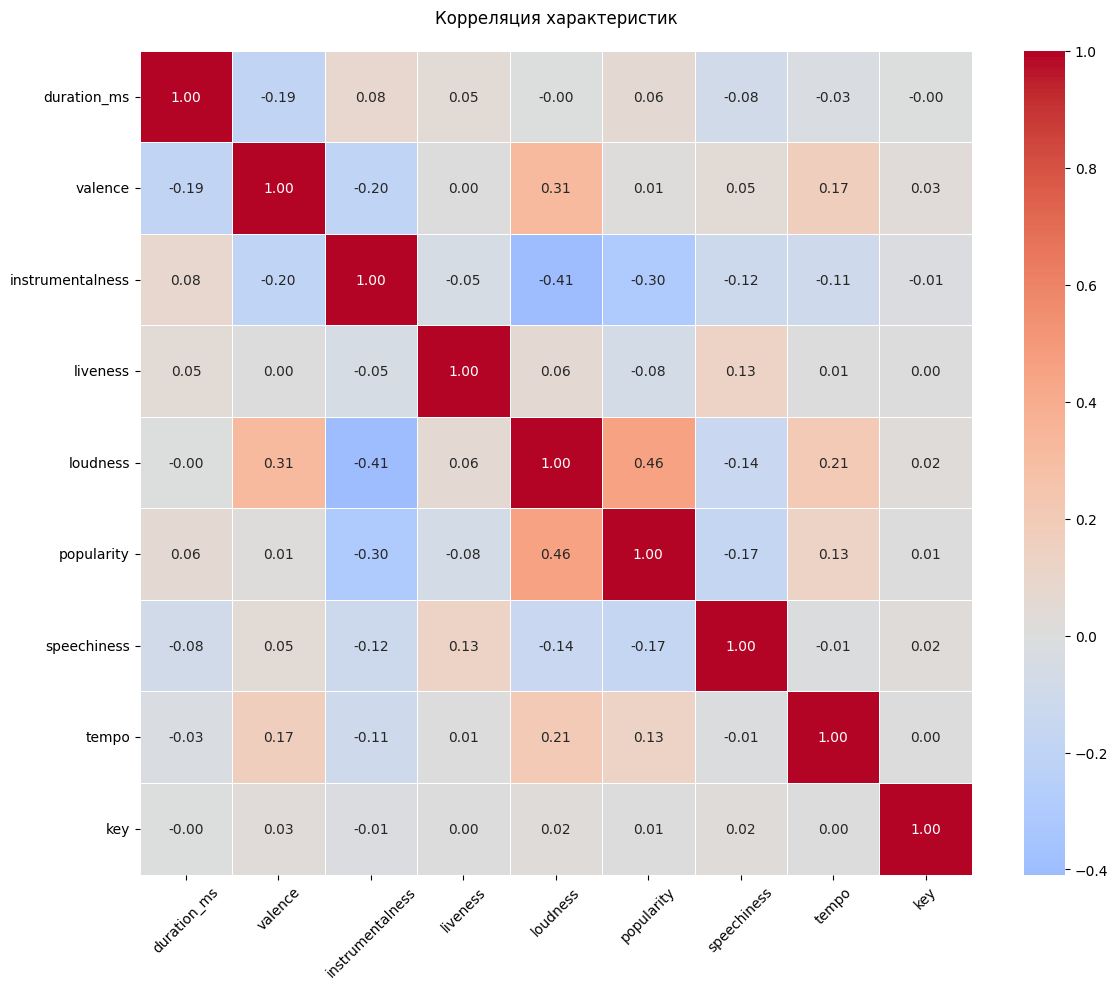

In [25]:
corr_matrix(main_data, selected_numeric_features)

Приведенная выше корреляционная матрица свидетельствует об отсутствии коррелирующих показателей.

На данном этапе мы определились с теми характеристиками композиций, которые мы будем изучать далее.

***Изучим категориальные данные***

В столбце "artists" данные представлены в формате строки, содержащей список строк. Такой формате неудобен для анализа, поэтому превратим формат данных в строку. В столбце "name" данные представлены в формате строки, поэтому оставим их без изменения.

In [26]:
main_data.artists = main_data.artists.apply(ast.literal_eval)
main_data.artists[0]

['Sergei Rachmaninoff', 'James Levine', 'Berliner Philharmoniker']

In [27]:
main_data.name[1000]

'Kapitel 26 - Der Page und die Herzogin'

In [28]:
main_data.head()

song_id  valence                                            artists  \
0        0   0.0594  [Sergei Rachmaninoff, James Levine, Berliner P...   
1        1   0.9630                                       [Dennis Day]   
2        2   0.0394  [KHP Kridhamardawa Karaton Ngayogyakarta Hadin...   
3        3   0.1650                                     [Frank Parker]   
4        4   0.2530                                       [Phil Regan]   

   duration_ms  instrumentalness  key  liveness  loudness  \
0       831667          0.878000   10     0.665   -20.096   
1       180533          0.000000    7     0.160   -12.441   
2       500062          0.913000    3     0.101   -14.850   
3       210000          0.000028    5     0.381    -9.316   
4       166693          0.000002    3     0.229   -10.096   

                                                name  popularity  speechiness  \
0  Piano Concerto No. 3 in D Minor, Op. 30: III. ...           4       0.0366   
1                            Clancy Lowered the Boom           5       0.4150   
2                                          Gati Bali           5       0.0339   
3                                          Danny Boy           3       0.0354   
4                        When Irish Eyes Are Smiling           2       0.0380   

     tempo  
0   80.954  
1   60.936  
2  110.339  
3  100.109  
4  101.665

#### **1.2 Предобработка датасета с жанрами композиций data_w_genres**

In [29]:
data_w_genres.head()

genres                                            artists  \
0  ['show tunes']                   "Cats" 1981 Original London Cast   
1              []                          "Cats" 1983 Broadway Cast   
2              []        "Fiddler On The Roof” Motion Picture Chorus   
3              []     "Fiddler On The Roof” Motion Picture Orchestra   
4              []  "Joseph And The Amazing Technicolor Dreamcoat"...   

   acousticness  danceability    duration_ms    energy  instrumentalness  \
0      0.590111      0.467222  250318.555556  0.394003          0.011400   
1      0.862538      0.441731  287280.000000  0.406808          0.081158   
2      0.856571      0.348286  328920.000000  0.286571          0.024593   
3      0.884926      0.425074  262890.962963  0.245770          0.073587   
4      0.510714      0.467143  270436.142857  0.488286          0.009400   

   liveness   loudness  speechiness       tempo   valence  popularity  key  \
0  0.290833 -14.448000     0.210389  117.518111  0.389500   38.333333    5   
1  0.315215 -10.690000     0.176212  103.044154  0.268865   30.576923    5   
2  0.325786 -15.230714     0.118514   77.375857  0.354857   34.857143    0   
3  0.275481 -15.639370     0.123200   88.667630  0.372030   34.851852    0   
4  0.195000 -10.236714     0.098543  122.835857  0.482286   43.000000    5   

   mode  count  
0     1      9  
1     1     26  
2     1      7  
3     1     27  
4     1      7

In [30]:
data_w_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28680 entries, 0 to 28679
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genres            28680 non-null  object 
 1   artists           28680 non-null  object 
 2   acousticness      28680 non-null  float64
 3   danceability      28680 non-null  float64
 4   duration_ms       28680 non-null  float64
 5   energy            28680 non-null  float64
 6   instrumentalness  28680 non-null  float64
 7   liveness          28680 non-null  float64
 8   loudness          28680 non-null  float64
 9   speechiness       28680 non-null  float64
 10  tempo             28680 non-null  float64
 11  valence           28680 non-null  float64
 12  popularity        28680 non-null  float64
 13  key               28680 non-null  int64  
 14  mode              28680 non-null  int64  
 15  count             28680 non-null  int64  
dtypes: float64(11), int64(3), object(2)
memo

В данном датасете для каждого исполнителя указан набор жанров, к которым относятся их композиции, а также приведены обобщенные характеристики его/ее композиций. Отмечаем, что в этом датасете нет отсутствующих данных.

#### ***Анализ числовых характеристик***

Поскольку характеристика "mode" является бинарной и не несет полезной информации, удалим ее

In [31]:
data_w_genres.drop("mode", axis=1, inplace=True)
data_w_genres.columns

Index(['genres', 'artists', 'acousticness', 'danceability', 'duration_ms',
       'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness',
       'tempo', 'valence', 'popularity', 'key', 'count'],
      dtype='object')

Выделим в отдельную переменную названия столбцов, содержащих числовые данные

In [32]:
artists_features = data_w_genres.columns[(data_w_genres.dtypes == "int") | (data_w_genres.dtypes == "float")]
artists_features

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'popularity', 'key', 'count'],
      dtype='object')

In [33]:
data_w_genres.describe()

acousticness  danceability   duration_ms        energy  \
count  28680.000000  28680.000000  2.868000e+04  28680.000000   
mean       0.498373      0.546490  2.388780e+05      0.497488   
std        0.370614      0.176474  1.211318e+05      0.254885   
min        0.000000      0.000000  1.879550e+04      0.000000   
25%        0.122296      0.431000  1.823304e+05      0.283568   
50%        0.478458      0.557000  2.186400e+05      0.504000   
75%        0.896000      0.675000  2.684670e+05      0.702783   
max        0.996000      0.986000  5.403500e+06      1.000000   

       instrumentalness      liveness      loudness   speechiness  \
count      28680.000000  28680.000000  28680.000000  28680.000000   
mean           0.174756      0.202441    -11.140498      0.094014   
std            0.298406      0.140884      5.771749      0.111986   
min            0.000000      0.000000    -60.000000      0.000000   
25%            0.000004      0.110362    -13.972292      0.039200   
50%            0.001880      0.161000    -10.088938      0.052200   
75%            0.215291      0.247000     -6.889000      0.095300   
max            1.000000      0.991000      1.342000      0.964000   

              tempo       valence    popularity           key         count  
count  28680.000000  28680.000000  28680.000000  28680.000000  28680.000000  
mean     115.844830      0.512723     34.060945      5.412901     13.847211  
std       25.003834      0.244421     22.376438      3.480552     53.372544  
min        0.000000      0.000000      0.000000      0.000000      1.000000  
25%       99.366500      0.329000     12.000000      2.000000      2.000000  
50%      115.357400      0.523243     39.000000      6.000000      3.000000  
75%      129.848750      0.703000     51.000000      8.000000      8.000000  
max      217.743000      0.991000     93.000000     11.000000   3169.000000

Как и в случае основного датасета, в данном датасете многие характеристики варьируют в границах диапазона от 0 до 1 (acousticness, danceability, energy и др.). Присутствуют характеристики с отрицательными значениями (loudness), бинарные характеристики (mode). Для характеристик instrumentalness, speechiness, count наблюдаются ярко выраженные "правые" хвосты (об этом свидетельствуют большие разбежки между 50 %, 75 % процентилями и макс. значениями).

Выполним визуализацию данных

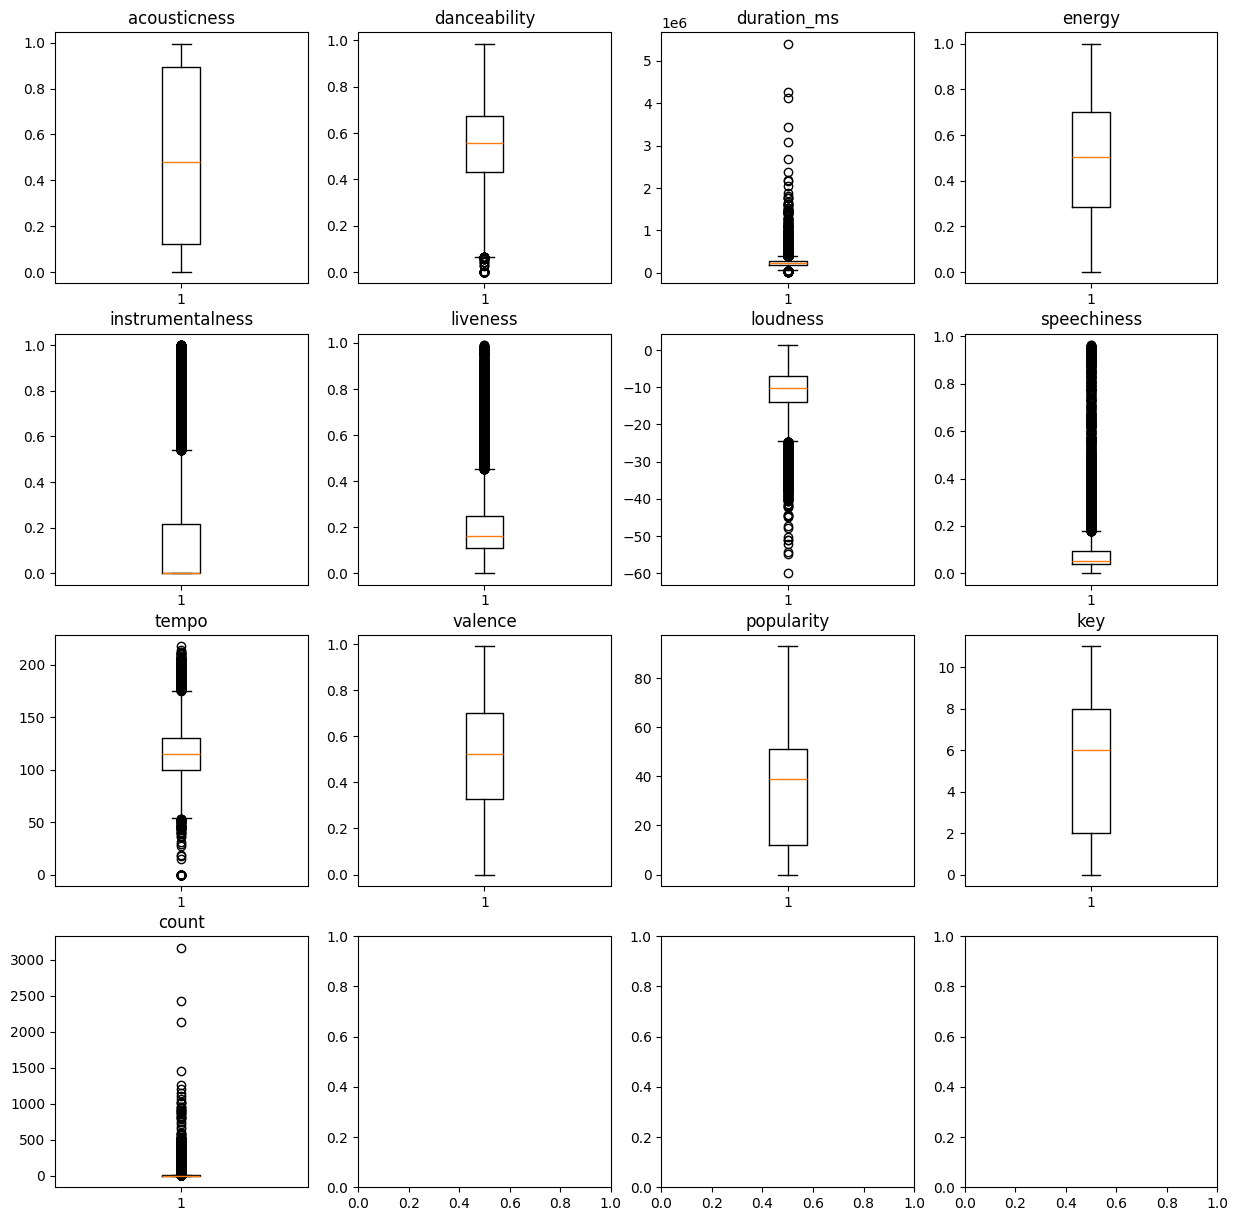

In [34]:
box_plot(data_w_genres, artists_features, n_rows=4, n_cols=4)

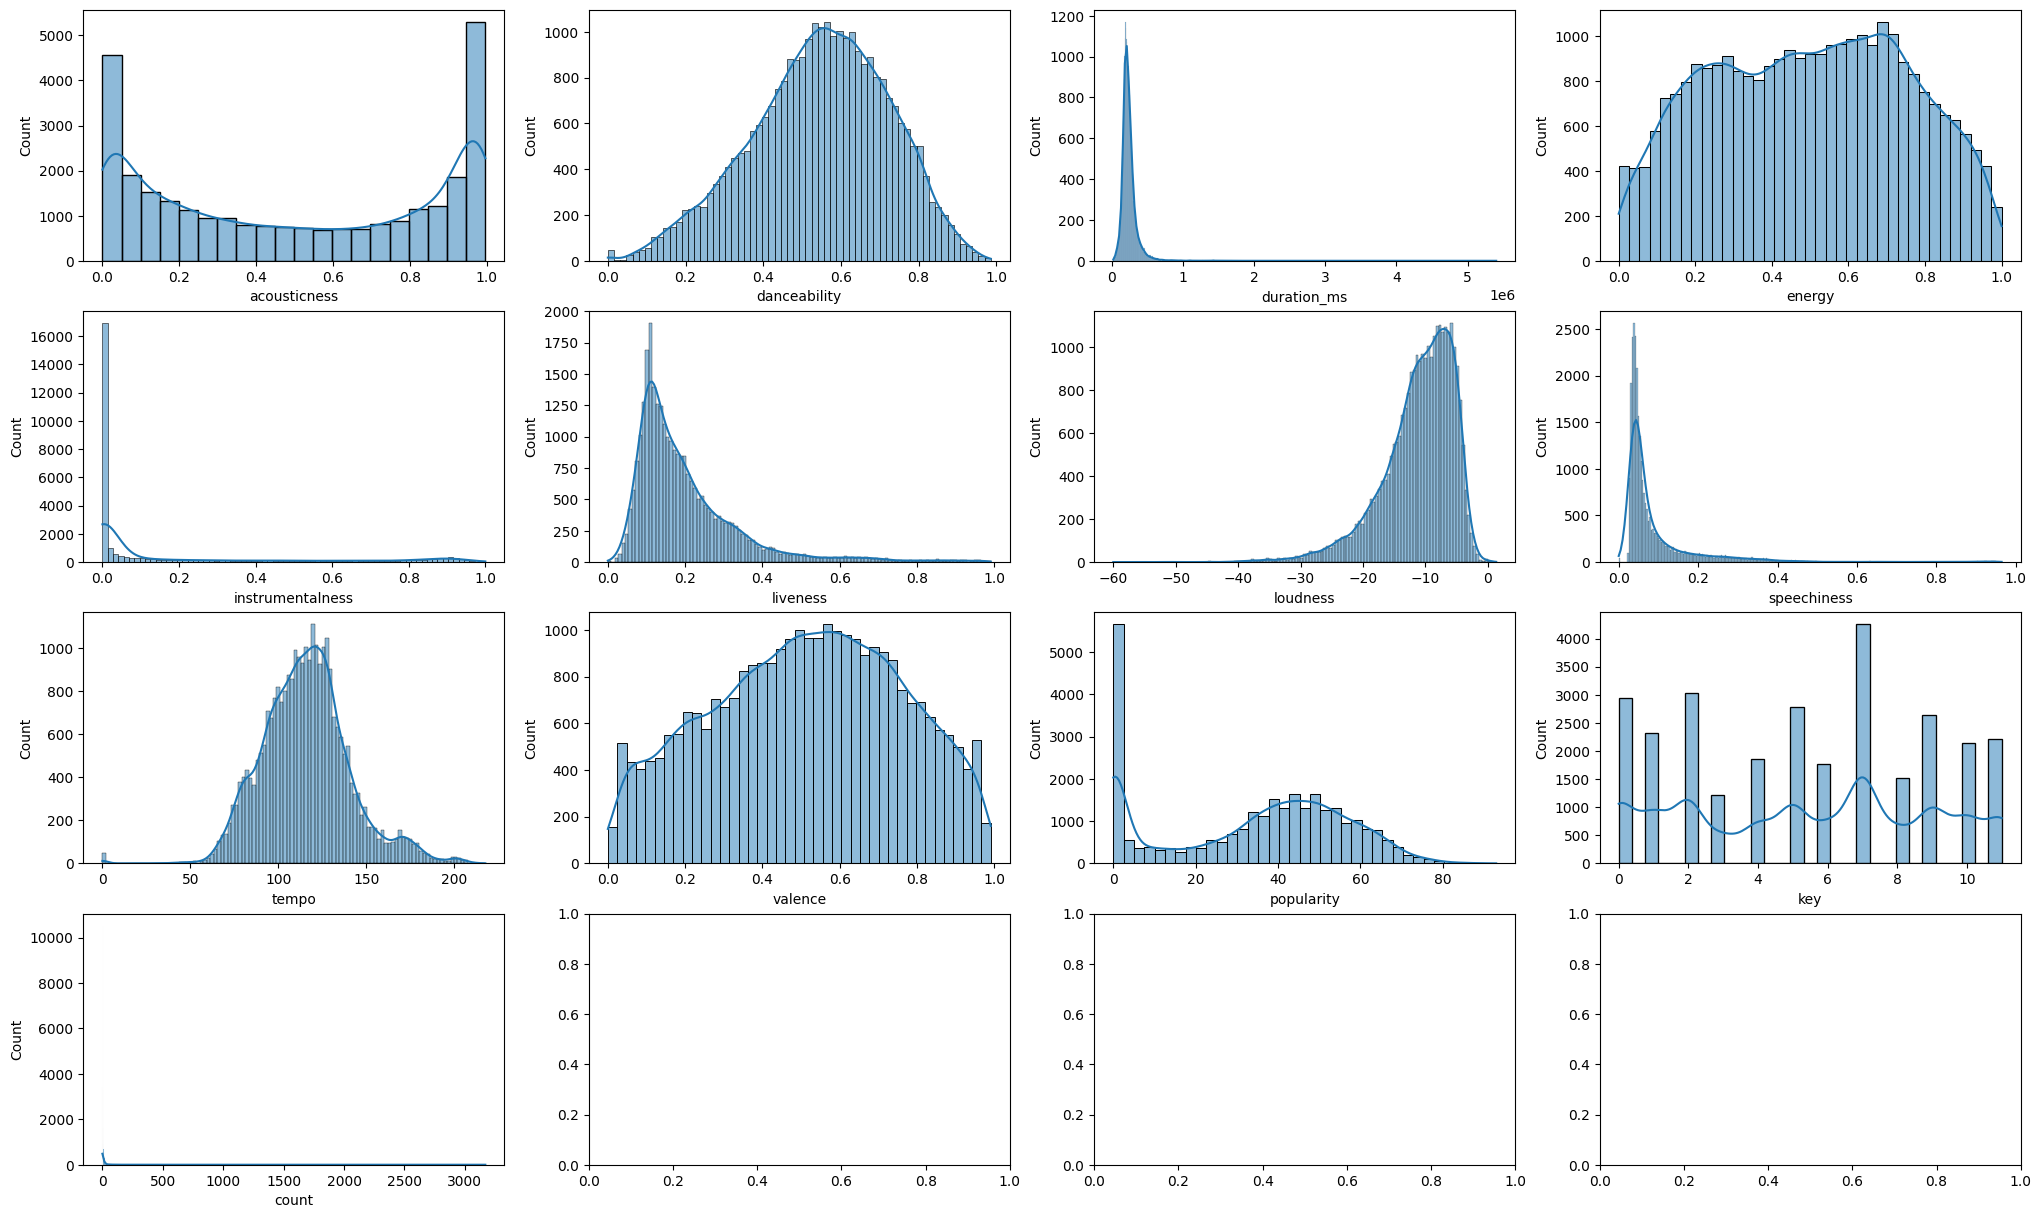

In [35]:
hist_plot(data_w_genres, artists_features, n_rows=4, n_cols=4)

В целом, распределение данных похоже на то, что наблюдалось для основного датасета. Также отмечаем, наличие выбросов практически у всех характеристик.

Оценим корреляцию между признаками в этом датасете

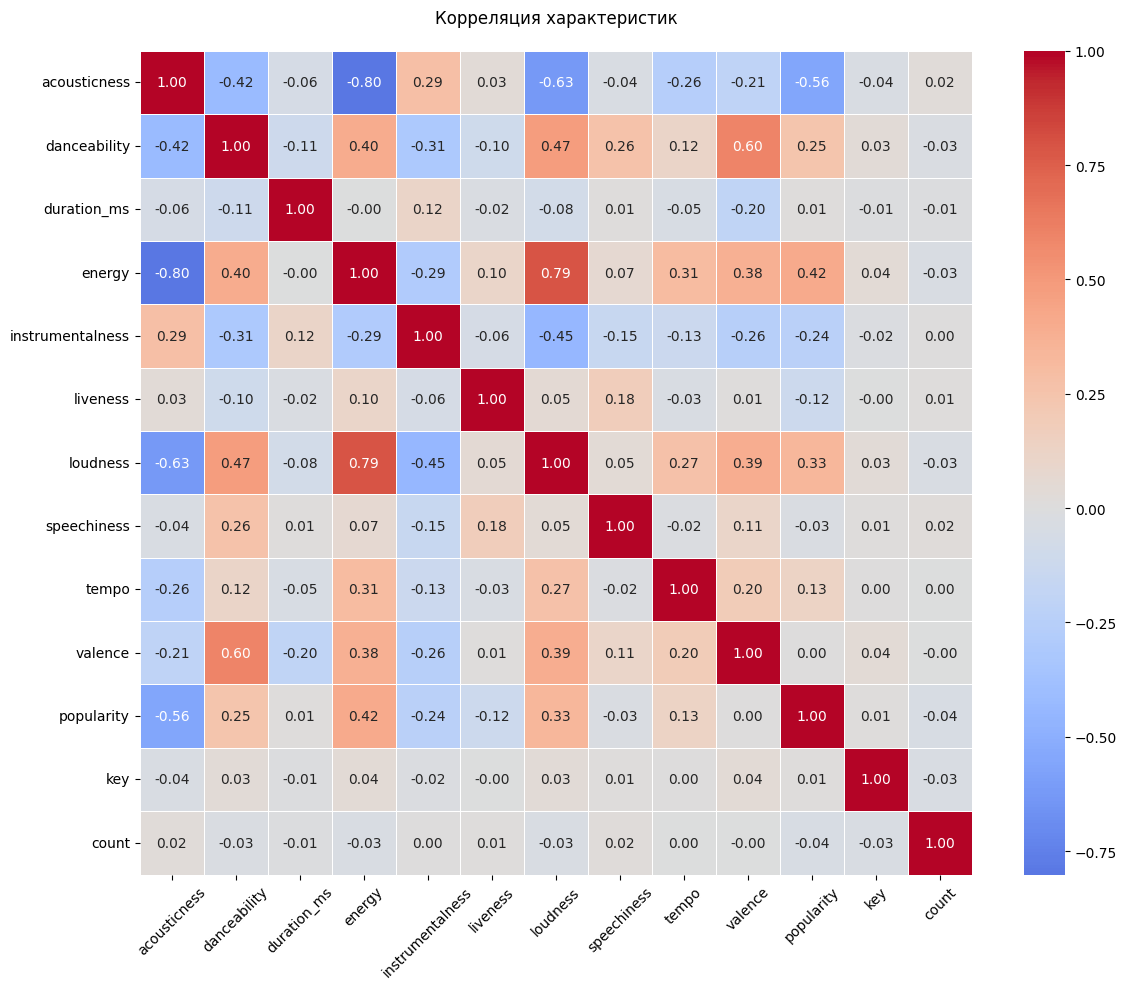

In [36]:
corr_matrix(data_w_genres, artists_features)

Как и в случае с основным датасетом, отмечаем высокую корреляцию между показателями "acousticness" и "energy", "acousticness" и "loudness", "acousticness" и "popularity", "danceability" и "valence", а также "loudness" и "energy". Для проверки наличия корреляции между показателями проведем статистический тест по Пирсону и Спирману.

In [37]:
check_correlation(data_w_genres, (["acousticness", "energy"],
                                ["acousticness", "loudness"],
                                 ["acousticness", "popularity"],
                                  ["danceability", "valence"],
                                  ["loudness", "energy"]))

Коэфф. корреляции и р-значение для показателей acousticness и energy по Пирсону и Спирману: (-0.801, 0.000) и (-0.802, 0.000)
Коэфф. корреляции и р-значение для показателей acousticness и loudness по Пирсону и Спирману: (-0.628, 0.000) и (-0.667, 0.000)
Коэфф. корреляции и р-значение для показателей acousticness и popularity по Пирсону и Спирману: (-0.557, 0.000) и (-0.515, 0.000)
Коэфф. корреляции и р-значение для показателей danceability и valence по Пирсону и Спирману: (0.599, 0.000) и (0.570, 0.000)
Коэфф. корреляции и р-значение для показателей loudness и energy по Пирсону и Спирману: (0.794, 0.000) и (0.829, 0.000)


In [38]:
correlated_artists_features = ["acousticness", "energy", "danceability"]
data_w_genres.drop(correlated_artists_features, axis=1, inplace=True)
data_w_genres.columns

Index(['genres', 'artists', 'duration_ms', 'instrumentalness', 'liveness',
       'loudness', 'speechiness', 'tempo', 'valence', 'popularity', 'key',
       'count'],
      dtype='object')

In [39]:
selected_artists_features = [feature for feature in artists_features if feature not in correlated_artists_features]
selected_artists_features

['duration_ms',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'valence',
 'popularity',
 'key',
 'count']

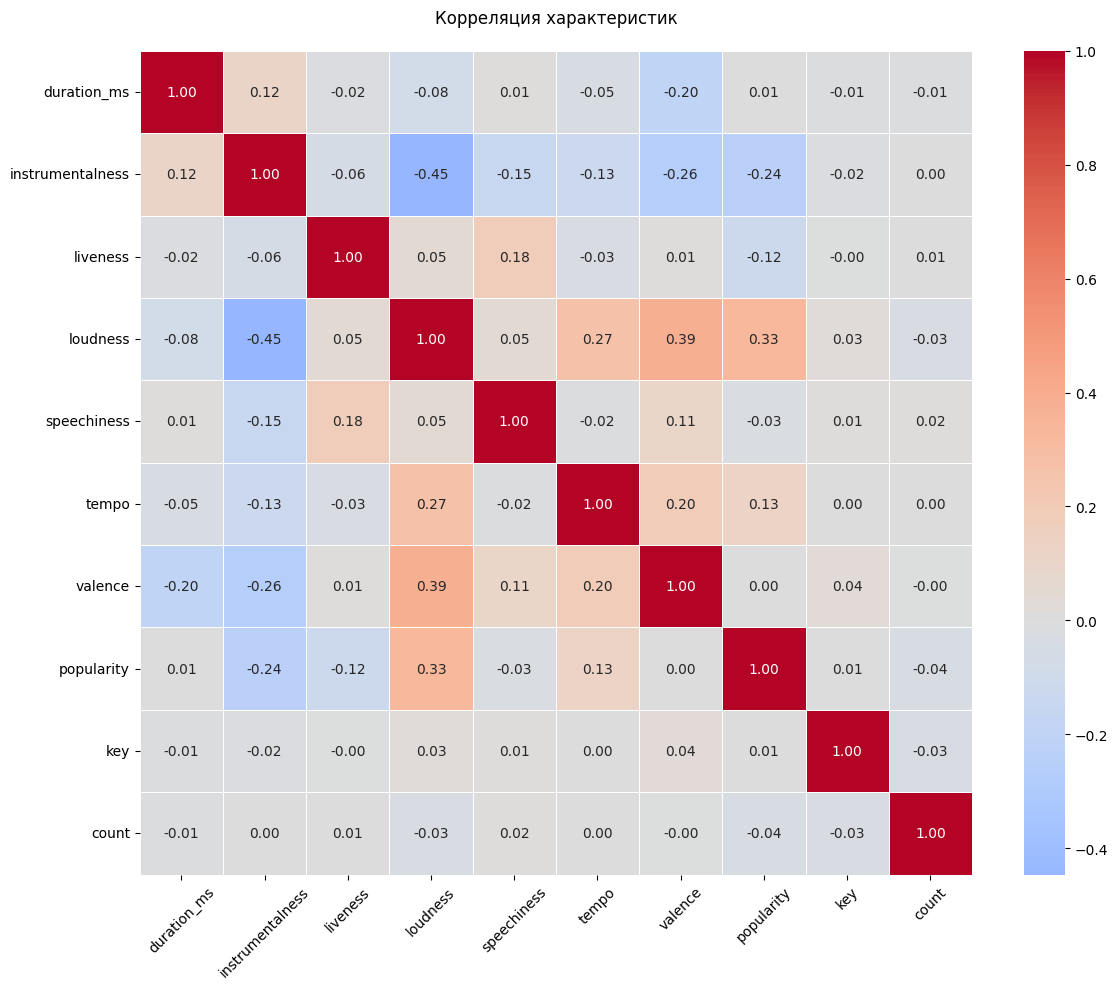

In [40]:
corr_matrix(data_w_genres, selected_artists_features)

#### ***Изучим категориальные данные***

В этом датасете присутствуют два категориальных показателя: genres и artists. Данные в столбце genres представлены в виде строки, включающей в себя список строк. Работа с таким форматом неудобна, поэтому преобразуем данные в формат строки.

In [41]:
data_w_genres['genres'] = data_w_genres['genres'].apply(ast.literal_eval)

In [42]:
isinstance(data_w_genres.genres[0], list)

True

В столбце "genres" в качестве "заглушки" для отсутствующих данных приведено []. Заменим данный символы на "unknown".

In [43]:
def process_genres(artist_genre_list):
    if not isinstance(artist_genre_list, list) or len(artist_genre_list) == 0:
        return ['unknown']
    return artist_genre_list

data_w_genres['genres_processed'] = data_w_genres['genres'].apply(process_genres)

In [44]:
data_w_genres.head()

genres                                            artists  \
0  [show tunes]                   "Cats" 1981 Original London Cast   
1            []                          "Cats" 1983 Broadway Cast   
2            []        "Fiddler On The Roof” Motion Picture Chorus   
3            []     "Fiddler On The Roof” Motion Picture Orchestra   
4            []  "Joseph And The Amazing Technicolor Dreamcoat"...   

     duration_ms  instrumentalness  liveness   loudness  speechiness  \
0  250318.555556          0.011400  0.290833 -14.448000     0.210389   
1  287280.000000          0.081158  0.315215 -10.690000     0.176212   
2  328920.000000          0.024593  0.325786 -15.230714     0.118514   
3  262890.962963          0.073587  0.275481 -15.639370     0.123200   
4  270436.142857          0.009400  0.195000 -10.236714     0.098543   

        tempo   valence  popularity  key  count genres_processed  
0  117.518111  0.389500   38.333333    5      9     [show tunes]  
1  103.044154  0.268865   30.576923    5     26        [unknown]  
2   77.375857  0.354857   34.857143    0      7        [unknown]  
3   88.667630  0.372030   34.851852    0     27        [unknown]  
4  122.835857  0.482286   43.000000    5      7        [unknown]

Кроме того, создадим словарь, в котором для каждого исполнителя соберем те жанры, к которым относятся его композиции. Этот словарь понадобится на следующем этапе при формировании жанровых характеристик композиций.

In [45]:
artists_genres_dict = {}
for i in range(len(data_w_genres)):
  artists_genres_dict[data_w_genres.loc[i, "artists"]] = data_w_genres.loc[i, "genres_processed"]

In [46]:
list(artists_genres_dict.items())[0:5]

[('"Cats" 1981 Original London Cast', ['show tunes']),
 ('"Cats" 1983 Broadway Cast', ['unknown']),
 ('"Fiddler On The Roof” Motion Picture Chorus', ['unknown']),
 ('"Fiddler On The Roof” Motion Picture Orchestra', ['unknown']),
 ('"Joseph And The Amazing Technicolor Dreamcoat" 1991 London Cast',
  ['unknown'])]

Обработка данного датасета завершена.

In [47]:
data_w_genres.head()

genres                                            artists  \
0  [show tunes]                   "Cats" 1981 Original London Cast   
1            []                          "Cats" 1983 Broadway Cast   
2            []        "Fiddler On The Roof” Motion Picture Chorus   
3            []     "Fiddler On The Roof” Motion Picture Orchestra   
4            []  "Joseph And The Amazing Technicolor Dreamcoat"...   

     duration_ms  instrumentalness  liveness   loudness  speechiness  \
0  250318.555556          0.011400  0.290833 -14.448000     0.210389   
1  287280.000000          0.081158  0.315215 -10.690000     0.176212   
2  328920.000000          0.024593  0.325786 -15.230714     0.118514   
3  262890.962963          0.073587  0.275481 -15.639370     0.123200   
4  270436.142857          0.009400  0.195000 -10.236714     0.098543   

        tempo   valence  popularity  key  count genres_processed  
0  117.518111  0.389500   38.333333    5      9     [show tunes]  
1  103.044154  0.268865   30.576923    5     26        [unknown]  
2   77.375857  0.354857   34.857143    0      7        [unknown]  
3   88.667630  0.372030   34.851852    0     27        [unknown]  
4  122.835857  0.482286   43.000000    5      7        [unknown]

### **1.3 Предобработка датасета data_by_genres**

In [48]:
data_by_genres.head()

mode                  genres  acousticness  danceability   duration_ms  \
0     1  21st century classical      0.979333      0.162883  1.602977e+05   
1     1                   432hz      0.494780      0.299333  1.048887e+06   
2     1                   8-bit      0.762000      0.712000  1.151770e+05   
3     1                      []      0.651417      0.529093  2.328809e+05   
4     1              a cappella      0.676557      0.538961  1.906285e+05   

     energy  instrumentalness  liveness   loudness  speechiness       tempo  \
0  0.071317          0.606834  0.361600 -31.514333     0.040567   75.336500   
1  0.450678          0.477762  0.131000 -16.854000     0.076817  120.285667   
2  0.818000          0.876000  0.126000  -9.180000     0.047000  133.444000   
3  0.419146          0.205309  0.218696 -12.288965     0.107872  112.857352   
4  0.316434          0.003003  0.172254 -12.479387     0.082851  112.110362   

    valence  popularity  key  
0  0.103783   27.833333    6  
1  0.221750   52.500000    5  
2  0.975000   48.000000    7  
3  0.513604   20.859882    7  
4  0.448249   45.820071    7

In [49]:
data_by_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2973 entries, 0 to 2972
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              2973 non-null   int64  
 1   genres            2973 non-null   object 
 2   acousticness      2973 non-null   float64
 3   danceability      2973 non-null   float64
 4   duration_ms       2973 non-null   float64
 5   energy            2973 non-null   float64
 6   instrumentalness  2973 non-null   float64
 7   liveness          2973 non-null   float64
 8   loudness          2973 non-null   float64
 9   speechiness       2973 non-null   float64
 10  tempo             2973 non-null   float64
 11  valence           2973 non-null   float64
 12  popularity        2973 non-null   float64
 13  key               2973 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 325.3+ KB


В данном датасете для каждого жанра приведены обобщенные характеристики композиций. Отмечаем, что в этом датасете нет отсутствующих данных. Все характеристики, за исключением "genres", являются числовыми. Проведем для этого датасета анализ, как и для предыдущих датасетов.

#### ***Анализ числовых показателей***

Как и в случае предыдущих датасетов, удалим характеристику "mode"

In [50]:
data_by_genres.drop("mode", axis=1, inplace=True)
data_by_genres.columns

Index(['genres', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'popularity', 'key'],
      dtype='object')

Выделим числовые характеристики для последующего анализа

In [51]:
genres_features = data_by_genres.columns[(data_by_genres.dtypes == "int") | (data_by_genres.dtypes == "float")]
genres_features

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'popularity', 'key'],
      dtype='object')

In [52]:
data_by_genres.describe()

acousticness  danceability   duration_ms       energy  \
count   2973.000000   2973.000000  2.973000e+03  2973.000000   
mean       0.401241      0.537187  2.517209e+05     0.561143   
std        0.319760      0.150668  9.465686e+04     0.234486   
min        0.000003      0.056900  3.094600e+04     0.001002   
25%        0.119050      0.441202  2.063788e+05     0.395058   
50%        0.321745      0.546496  2.375453e+05     0.601195   
75%        0.673991      0.647500  2.772720e+05     0.730127   
max        0.996000      0.929000  2.382587e+06     0.994667   

       instrumentalness     liveness     loudness  speechiness        tempo  \
count       2973.000000  2973.000000  2973.000000  2973.000000  2973.000000   
mean           0.211366     0.192800   -10.509848     0.083588   119.018723   
std            0.267329     0.092356     5.369202     0.080483    17.469188   
min            0.000000     0.022200   -41.825000     0.023800    47.135722   
25%            0.004835     0.137687   -12.427656     0.044900   109.198143   
50%            0.080700     0.178764    -9.221817     0.059457   119.194167   
75%            0.343333     0.220856    -6.920125     0.091000   127.508750   
max            0.992000     0.960000     0.060000     0.946219   204.212000   

           valence   popularity          key  
count  2973.000000  2973.000000  2973.000000  
mean      0.492748    39.919185     5.938782  
std       0.201820    16.748723     3.368110  
min       0.003353     0.000000     0.000000  
25%       0.348578    32.491279     3.000000  
50%       0.500048    43.056569     7.000000  
75%       0.640257    51.138889     9.000000  
max       0.980000    80.666667    11.000000

Как и в случае предыдущих датасетов, в данном датасете многие характеристики варьируют в границах диапазона от 0 до 1 (acousticness, danceability, energy и др.). Присутствуют характеристики с отрицательными значениями (loudness). Для характеристики "speechiness" наблюдаются ярко выраженный "правый" хвост (об этом свидетельствуют большие разбежки между 50 %, 75 % процентилями и макс. значениями). Однако следует отметить, что в отличие от предыдущих датасетов (характеристики отдельных композиций и обобщенные характеристики композиций в зависимости от исполнителя) разброс характеристик композиций в этом датасете значительно меньше, т.е. жанры является более однородными с точки зрения характеристик композиций, т.е исполнители.

Выполним визуализацию данных

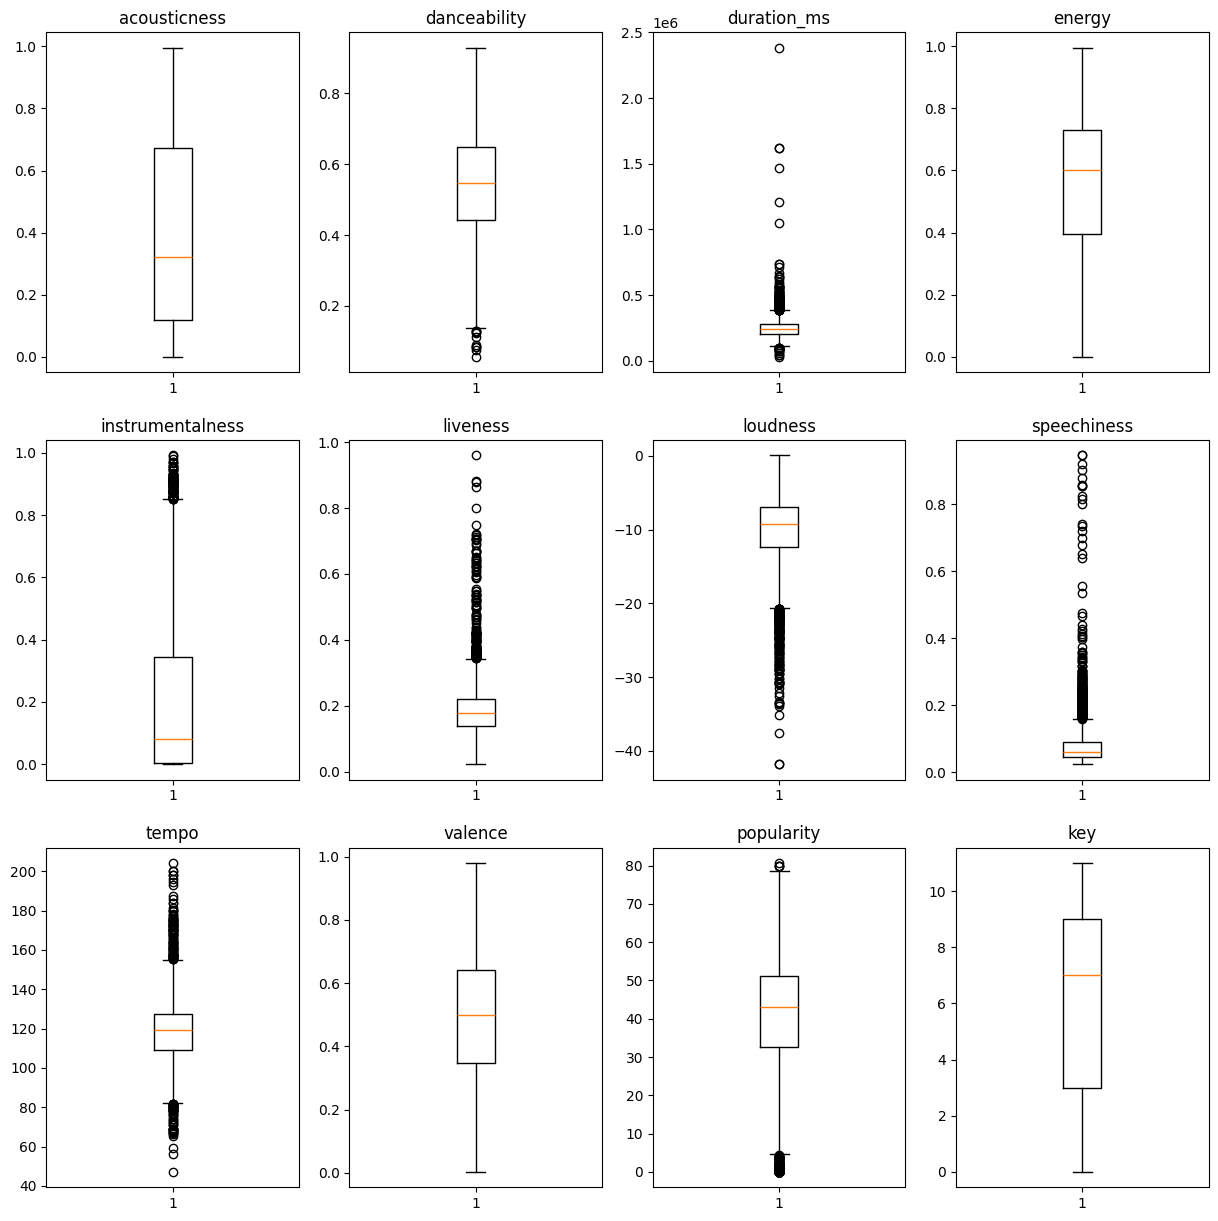

In [53]:
box_plot(data_by_genres, genres_features, n_rows = 3, n_cols=4)

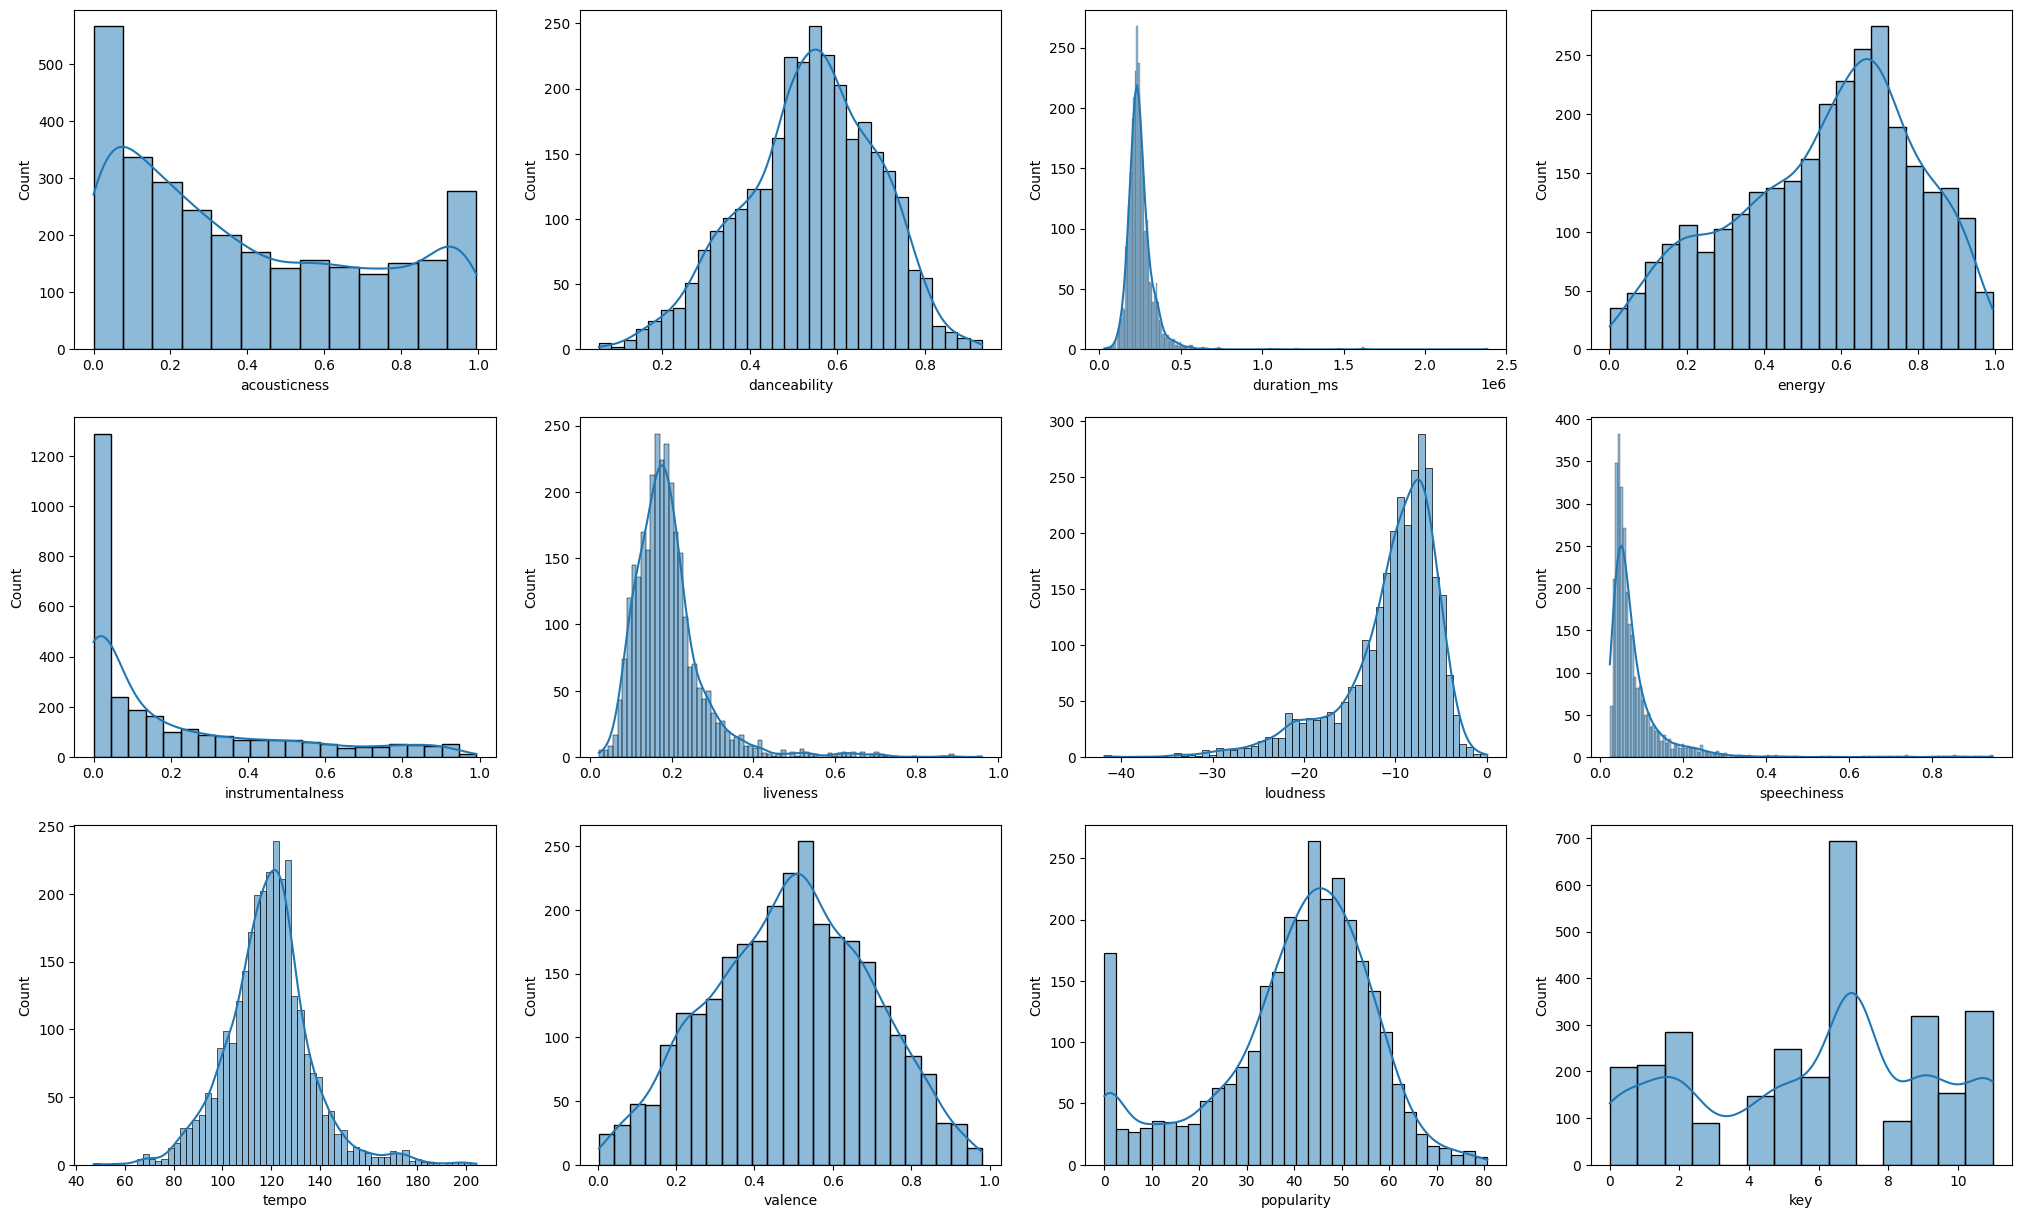

In [54]:
hist_plot(data_by_genres, genres_features, n_rows = 3, n_cols=4)

Представленные выше диаграммы подтверждают предположение о более однородной структуре характеристик композиций для жанров. Распределение характеристик ближе к нормальному, хвосты менее выражены. Тем не менее, выбросы присутствуют. Поэтому эти данные более удобны для проведения кластеризации.

Выполним проверку на наличие корреляции между признаками

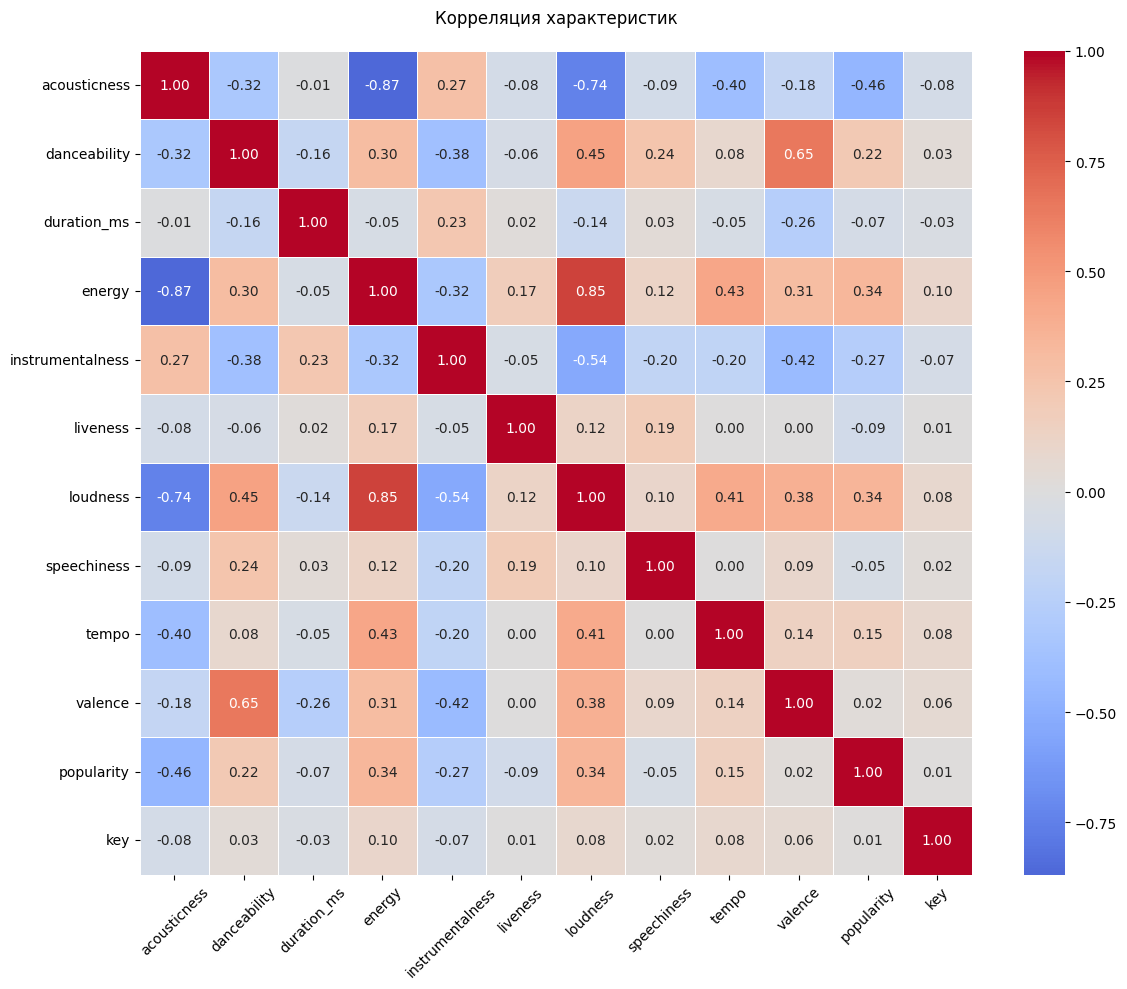

In [55]:
corr_matrix(data_by_genres, genres_features)

Как и в случае с предыдущими датасетами, отмечаем высокую корреляцию между показателями "acousticness" и "energy", "acousticness" и "loudness", "acousticness" и "popularity", "danceability" и "valence", а также "loudness" и "energy". Для проверки наличия корреляции между показателями проведем статистический тест по Пирсону и Спирману.

In [56]:
check_correlation(data_by_genres, (["acousticness", "energy"],
                                ["acousticness", "loudness"],
                                 ["acousticness", "popularity"],
                                  ["danceability", "valence"],
                                  ["loudness", "energy"]))

Коэфф. корреляции и р-значение для показателей acousticness и energy по Пирсону и Спирману: (-0.868, 0.000) и (-0.861, 0.000)
Коэфф. корреляции и р-значение для показателей acousticness и loudness по Пирсону и Спирману: (-0.737, 0.000) и (-0.736, 0.000)
Коэфф. корреляции и р-значение для показателей acousticness и popularity по Пирсону и Спирману: (-0.459, 0.000) и (-0.391, 0.000)
Коэфф. корреляции и р-значение для показателей danceability и valence по Пирсону и Спирману: (0.653, 0.000) и (0.632, 0.000)
Коэфф. корреляции и р-значение для показателей loudness и energy по Пирсону и Спирману: (0.849, 0.000) и (0.843, 0.000)


In [57]:
correlated_genres_features = ["acousticness", "energy", "danceability"]
data_by_genres.drop(correlated_genres_features, axis=1, inplace=True)
data_by_genres.columns

Index(['genres', 'duration_ms', 'instrumentalness', 'liveness', 'loudness',
       'speechiness', 'tempo', 'valence', 'popularity', 'key'],
      dtype='object')

In [58]:
selected_genres_features = [feature for feature in genres_features if feature not in correlated_genres_features]
selected_genres_features

['duration_ms',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'valence',
 'popularity',
 'key']

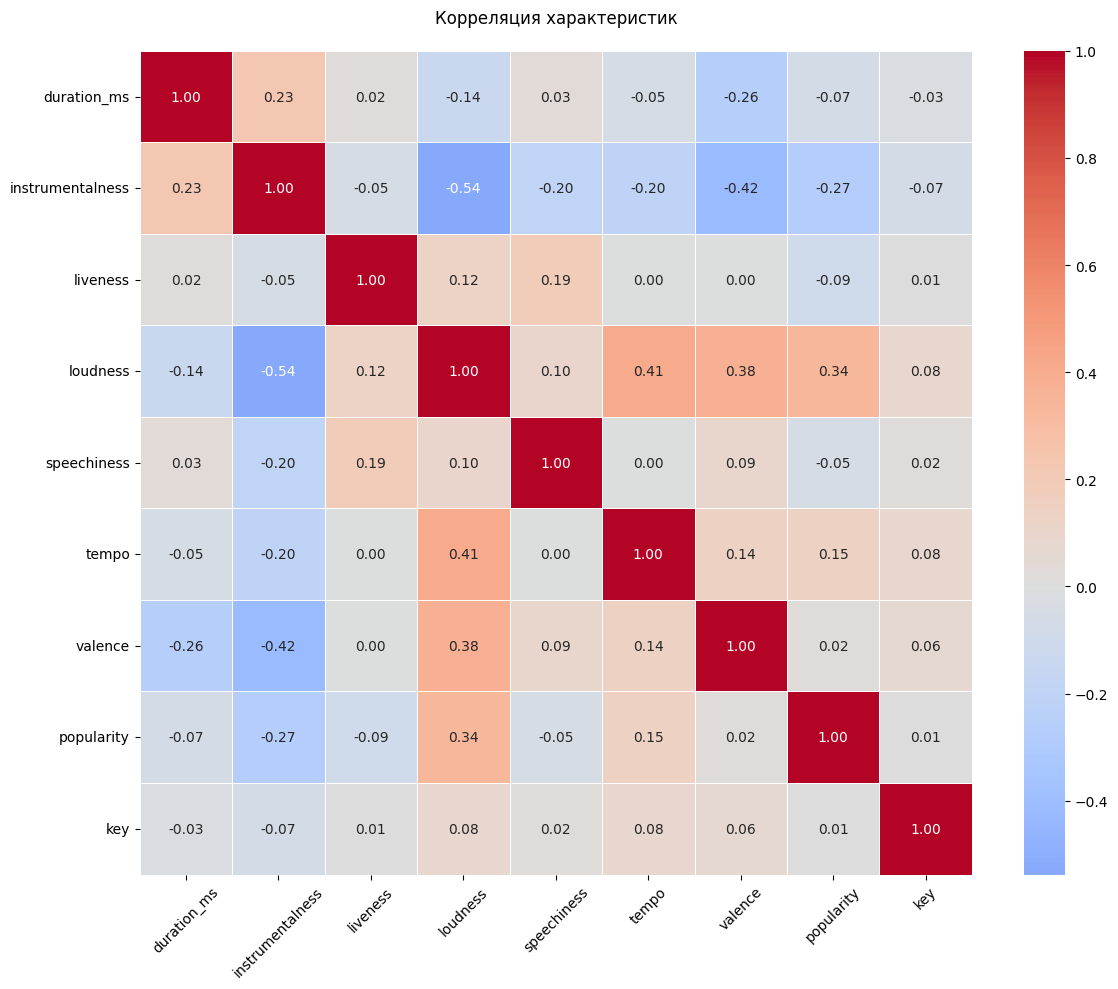

In [59]:
corr_matrix(data_by_genres, selected_genres_features)

#### ***Изучим категориальные признаки***

В этом датасете присутствует один категориальный показатель: genres. Данные в этом столбце не требуют преобразования. Однако в нем присутствуют значения "[]". Заменим их на "unknown".

In [60]:
for i in range(len(data_by_genres)):
  if data_by_genres.loc[i, "genres"] == "[]":
    data_by_genres.loc[i, "genres"] = "unknown"
data_by_genres.head()

genres   duration_ms  instrumentalness  liveness  \
0  21st century classical  1.602977e+05          0.606834  0.361600   
1                   432hz  1.048887e+06          0.477762  0.131000   
2                   8-bit  1.151770e+05          0.876000  0.126000   
3                 unknown  2.328809e+05          0.205309  0.218696   
4              a cappella  1.906285e+05          0.003003  0.172254   

    loudness  speechiness       tempo   valence  popularity  key  
0 -31.514333     0.040567   75.336500  0.103783   27.833333    6  
1 -16.854000     0.076817  120.285667  0.221750   52.500000    5  
2  -9.180000     0.047000  133.444000  0.975000   48.000000    7  
3 -12.288965     0.107872  112.857352  0.513604   20.859882    7  
4 -12.479387     0.082851  112.110362  0.448249   45.820071    7

### **2. Создание рекомендательной системы на основе кластеризации**

#### **2.1 Объединение данных из разных датасетов**

Перед нами стоит цель создания рекомендательной системы, которая будет рекомендовать композиции, сходные с предложенной композицией, по стилю и жанру. За стиль отвечают признаки, присутствующие в основном датасете. За жанр отвечают признаки жанров, которые мы получим из датасетов исполнителей и жанров (data_w_genres и data_by_genres). Поэтому эти признаки необходимо добавить в основной датасет и провести кластеризацию. За стиль отвечают аудиохарактеристики самих композиций. Эти характеристики будет применяться для расчета близости композиций по косинусному расстоянию.

Прежде всего, выделим в словарь характеристики жанров, полученные из третьего датасета (датасет с характеристиками жанров, data_by_genres).

In [61]:
genre_to_features = data_by_genres.set_index("genres").to_dict("index")
list(genre_to_features.items())[0:3]

[('21st century classical',
  {'duration_ms': 160297.66666666663,
   'instrumentalness': 0.60683367,
   'liveness': 0.3616,
   'loudness': -31.514333333333337,
   'speechiness': 0.0405666666666666,
   'tempo': 75.3365,
   'valence': 0.1037833333333333,
   'popularity': 27.83333333333333,
   'key': 6}),
 ('432hz',
  {'duration_ms': 1048887.333333333,
   'instrumentalness': 0.4777616666666668,
   'liveness': 0.131,
   'loudness': -16.854,
   'speechiness': 0.0768166666666666,
   'tempo': 120.28566666666666,
   'valence': 0.22175,
   'popularity': 52.5,
   'key': 5}),
 ('8-bit',
  {'duration_ms': 115177.0,
   'instrumentalness': 0.8759999999999999,
   'liveness': 0.126,
   'loudness': -9.18,
   'speechiness': 0.047,
   'tempo': 133.444,
   'valence': 0.975,
   'popularity': 48.0,
   'key': 7})]

Ранее у нас уже был создан словарь, в котором для каждого исполнителя был указан набор жанров его композиций:

In [62]:
list(artists_genres_dict.items())[0:3]

[('"Cats" 1981 Original London Cast', ['show tunes']),
 ('"Cats" 1983 Broadway Cast', ['unknown']),
 ('"Fiddler On The Roof” Motion Picture Chorus', ['unknown'])]

Создадим функцию, которая бы принимала на вход список жанров для каждого исполнителя и выдавала бы усредненные (если жанров несколько) характеристики этих жанров. Тем самым, мы для каждого исполнителя получим набор обобщенных характеристик, соответствующих тем жанрам, которые относятся к исполнителю. Собранные данные применим к столбцу "artists" в основном датасете (main_data), учитывая, что в этом столбце данные приведены в формате списка. Поэтому предварительно создадим список исполнителей для всех композиций.

In [63]:
def add_genre_features(tracks_df, artist_to_genres, genre_to_features):
    """
    Вычисляет усредненные жанровые характеристики для всех треков в tracks_df.

    Параметры:
    - tracks_df: DataFrame с колонкой 'artists' (списки исполнителей для каждого трека)
    - artist_to_genres: словарь {исполнитель: [жанры]}
    - genre_to_features: словарь {жанр: {характеристики}}

    Возвращает:
    - DataFrame tracks_df с добавленными колонками genre_{feature}
    """
    all_track_features = []


    for artists_list in tracks_df["artists"]:
        collected_features = []

        for artist in artists_list:
            artist_genres = artist_to_genres.get(artist, [])
            for genre in artist_genres:
                if genre in genre_to_features:
                    collected_features.append(list(genre_to_features[genre].values()))

        if collected_features:
            avg_features = np.mean(collected_features, axis=0)
        else:
            avg_features = None

        all_track_features.append(avg_features)

    tracks_df["genre_features"] = all_track_features

    if not tracks_df["genre_features"].isna().all():
        feature_names = list(next(iter(genre_to_features.values())).keys())
        features_array = np.vstack(tracks_df["genre_features"].dropna())

        features_df = pd.DataFrame(
            features_array,
            index=tracks_df["genre_features"].dropna().index,
            columns=[f"genre_{name}" for name in feature_names]
        )

        tracks_df = tracks_df.join(features_df)

    tracks_df.drop("genre_features", axis=1, inplace=True)

    return tracks_df

main_data = add_genre_features(main_data, artists_genres_dict, genre_to_features)

In [64]:
main_data.head()

song_id  valence                                            artists  \
0        0   0.0594  [Sergei Rachmaninoff, James Levine, Berliner P...   
1        1   0.9630                                       [Dennis Day]   
2        2   0.0394  [KHP Kridhamardawa Karaton Ngayogyakarta Hadin...   
3        3   0.1650                                     [Frank Parker]   
4        4   0.2530                                       [Phil Regan]   

   duration_ms  instrumentalness  key  liveness  loudness  \
0       831667          0.878000   10     0.665   -20.096   
1       180533          0.000000    7     0.160   -12.441   
2       500062          0.913000    3     0.101   -14.850   
3       210000          0.000028    5     0.381    -9.316   
4       166693          0.000002    3     0.229   -10.096   

                                                name  popularity  ...  \
0  Piano Concerto No. 3 in D Minor, Op. 30: III. ...           4  ...   
1                            Clancy Lowered the Boom           5  ...   
2                                          Gati Bali           5  ...   
3                                          Danny Boy           3  ...   
4                        When Irish Eyes Are Smiling           2  ...   

     tempo  genre_duration_ms  genre_instrumentalness  genre_liveness  \
0   80.954      314077.093872                0.506781        0.184188   
1   60.936      232880.890250                0.205309        0.218696   
2  110.339      232880.890250                0.205309        0.218696   
3  100.109      232880.890250                0.205309        0.218696   
4  101.665      232880.890250                0.205309        0.218696   

   genre_loudness  genre_speechiness  genre_tempo  genre_valence  \
0      -20.531733           0.051411   101.262103       0.218231   
1      -12.288965           0.107872   112.857352       0.513604   
2      -12.288965           0.107872   112.857352       0.513604   
3      -12.288965           0.107872   112.857352       0.513604   
4      -12.288965           0.107872   112.857352       0.513604   

   genre_popularity  genre_key  
0         20.281796        5.0  
1         20.859882        7.0  
2         20.859882        7.0  
3         20.859882        7.0  
4         20.859882        7.0  

[5 rows x 21 columns]

Определим числовые признаки для нового датасета



In [65]:
features_to_exclude = ["artists", "name", "song_id"]
numeric_features = [feature for feature in main_data.columns if feature not in features_to_exclude]
numeric_features

['valence',
 'duration_ms',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'popularity',
 'speechiness',
 'tempo',
 'genre_duration_ms',
 'genre_instrumentalness',
 'genre_liveness',
 'genre_loudness',
 'genre_speechiness',
 'genre_tempo',
 'genre_valence',
 'genre_popularity',
 'genre_key']

Визуализируем датасет с агрегированными данными

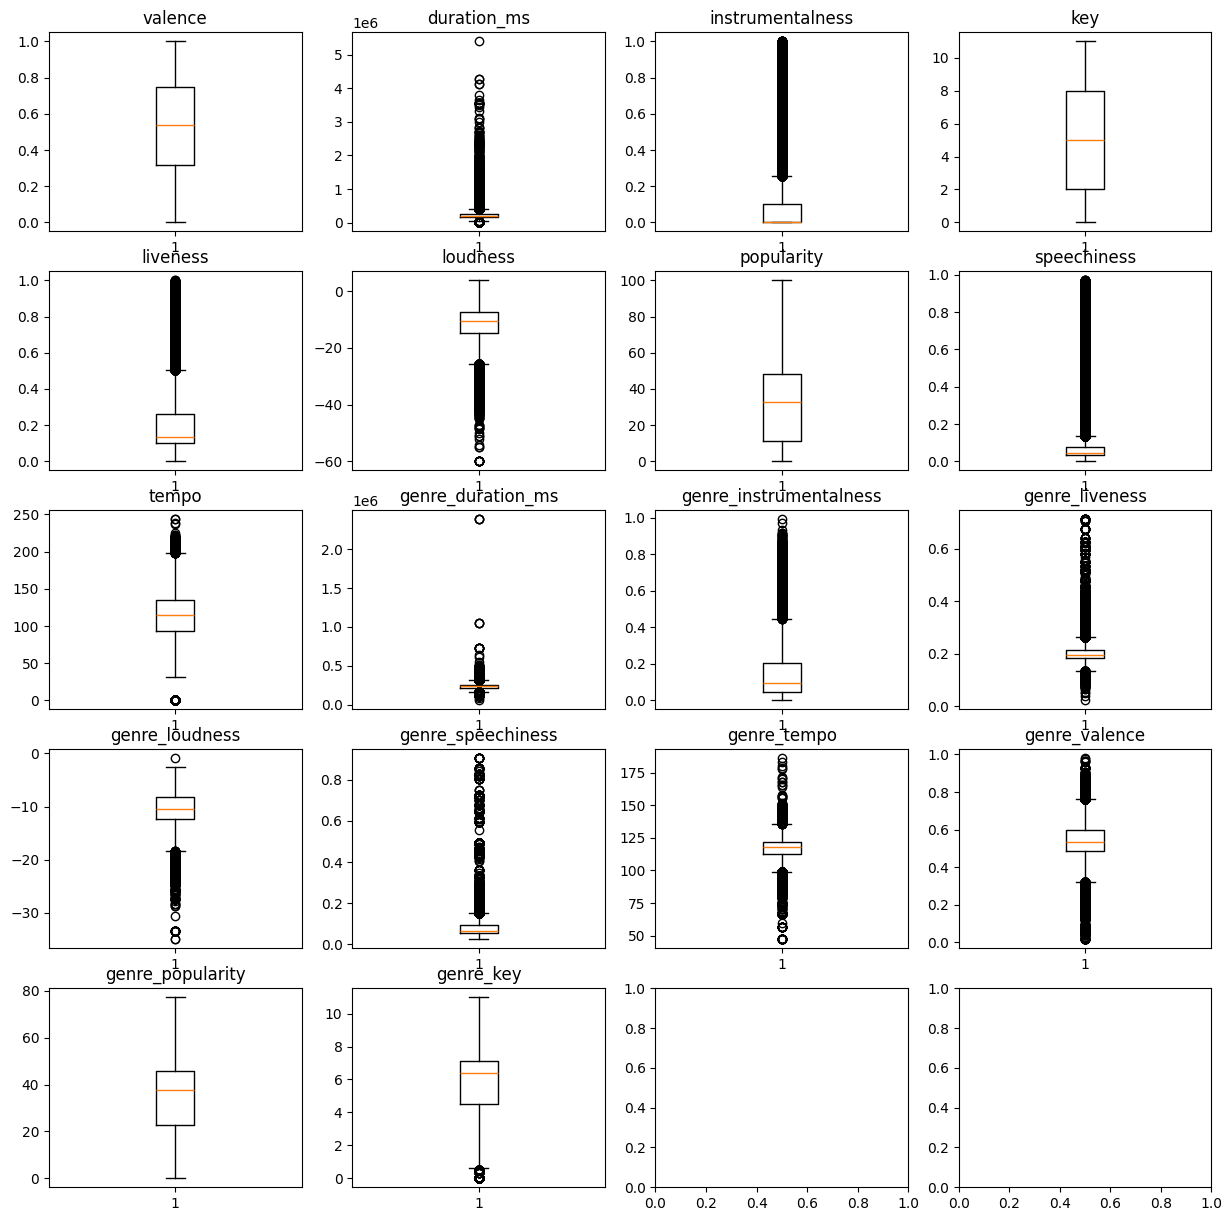

In [66]:
box_plot(main_data, numeric_features, n_rows=5, n_cols=4)

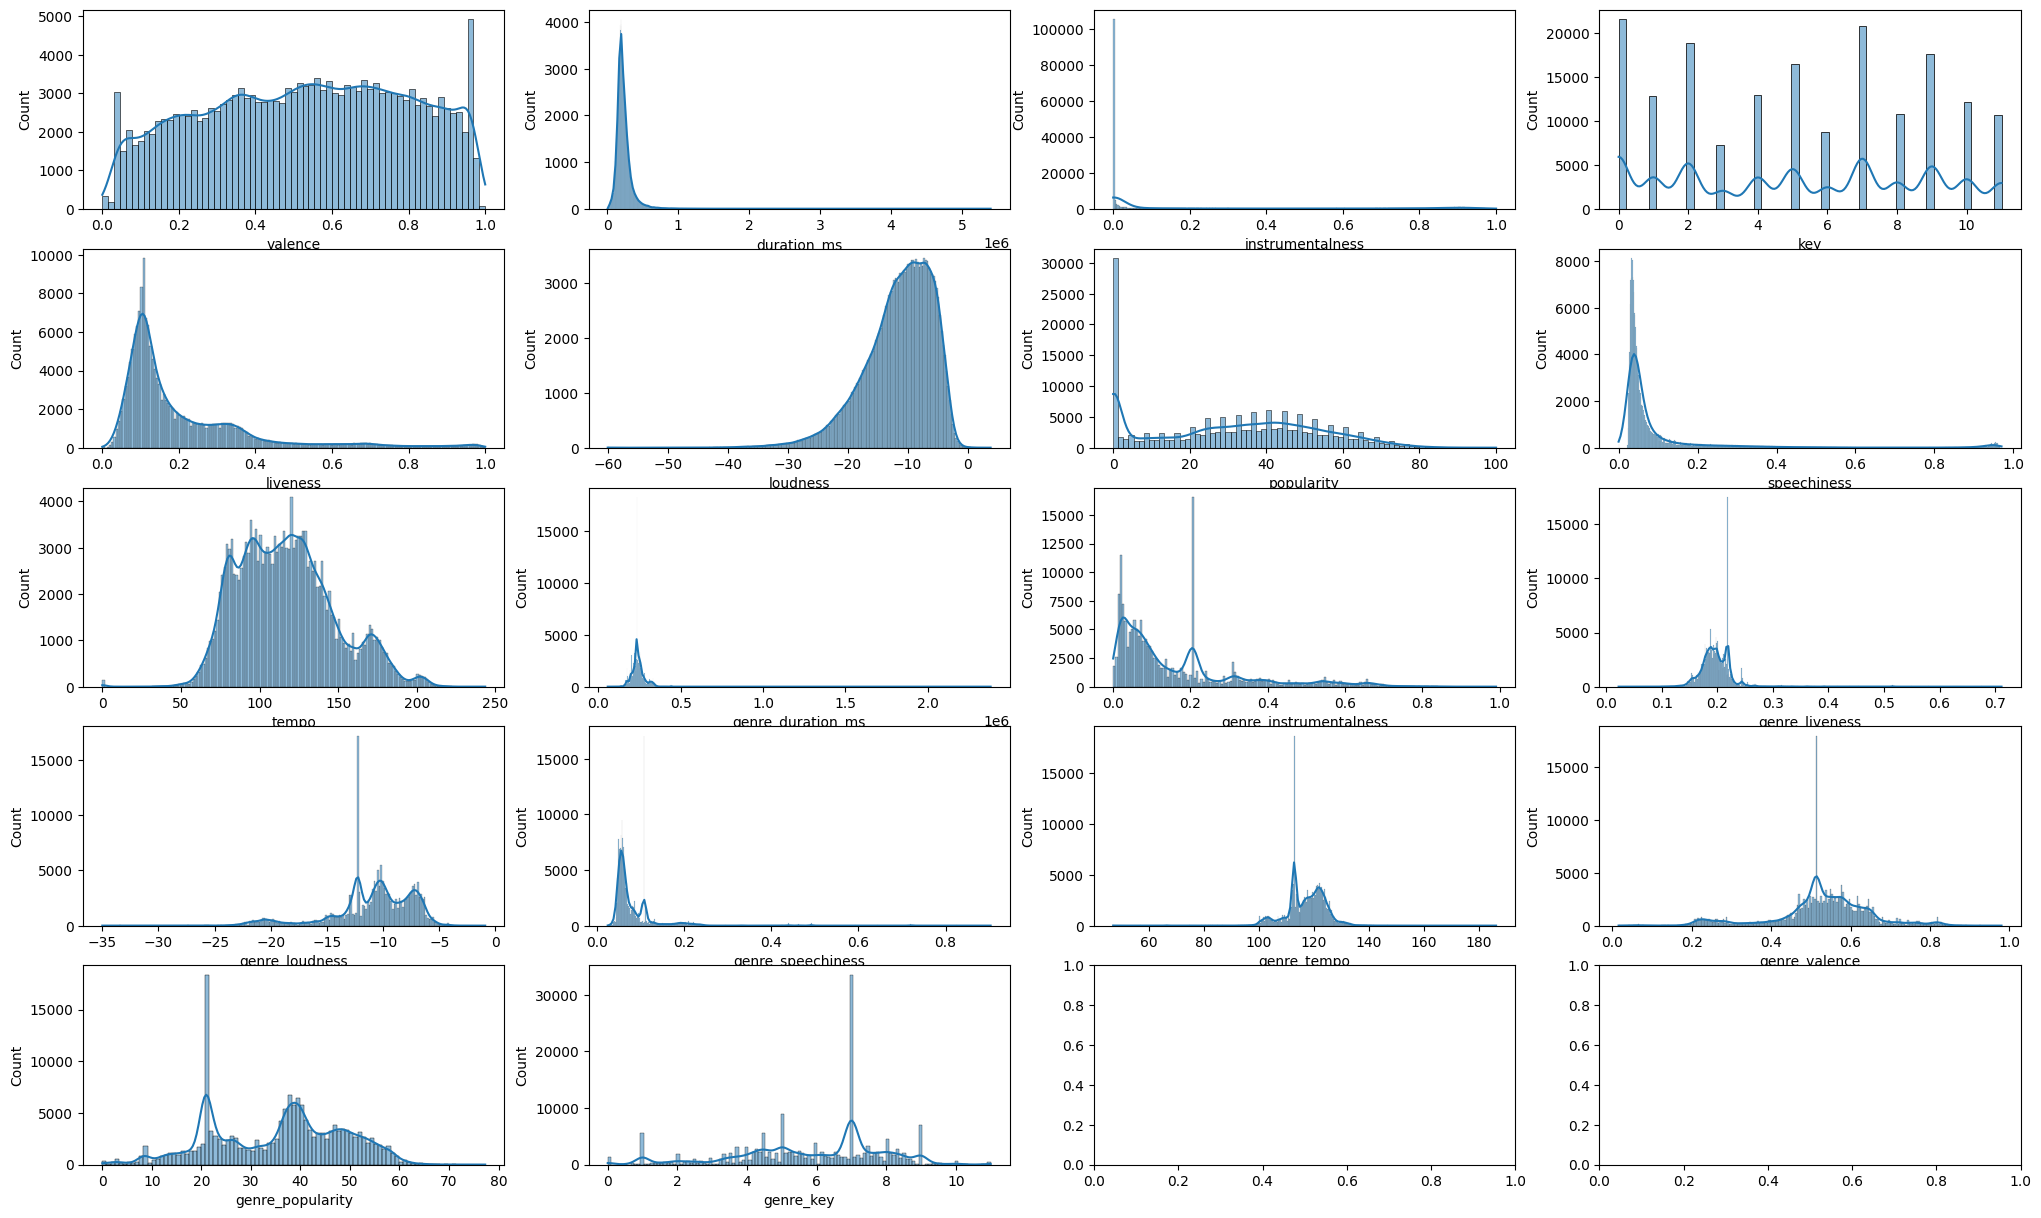

In [67]:
hist_plot(main_data, numeric_features, n_rows=5, n_cols=4)

Отмечаем, что агрегированные данные имеют выбросы. Эти выбросы могут оказать влияние на результаты кластеризации (KMeans), поэтому выполним замену выбросов на медиану. Вновь визуализируем данные

Для устранения хвостов в распределении значений различных показателей проведем логарифмическую трансформацию данных. Однако следует учитывать, что многие показатели принимают нулевые значения, а некоторые показатели - отрицательные значения. Проводить классическое логарифмирование таких показателей невозможно. Поэтому используем подход Yeo-Johnson для преобразования данных, который позволяет работать с такого рода данными.

In [68]:
def log_transform(data, features):
    pt = PowerTransformer(method='yeo-johnson')
    for feature in features:
        transformed_data = pt.fit_transform(data[[feature]])
        data[feature] = transformed_data

Кроме того, разработаем функцию для замены выбросов медианным значением

In [69]:
def remove_outliers(data, features, lower_percentile=0.025, upper_percentile=0.975):

    if isinstance(features, str):
        features = [features]

    for feature in features:
        lower = np.percentile(data[feature], 100 * lower_percentile)
        upper = np.percentile(data[feature], 100 * upper_percentile)

        mask = (data[feature] >= lower) & (data[feature] <= upper)
        mask = mask.fillna(False)

        median = np.median(data[feature][mask])

        data[feature] = np.where(mask, data[feature], median)

In [70]:
log_transform(main_data, numeric_features)
remove_outliers(main_data, numeric_features)

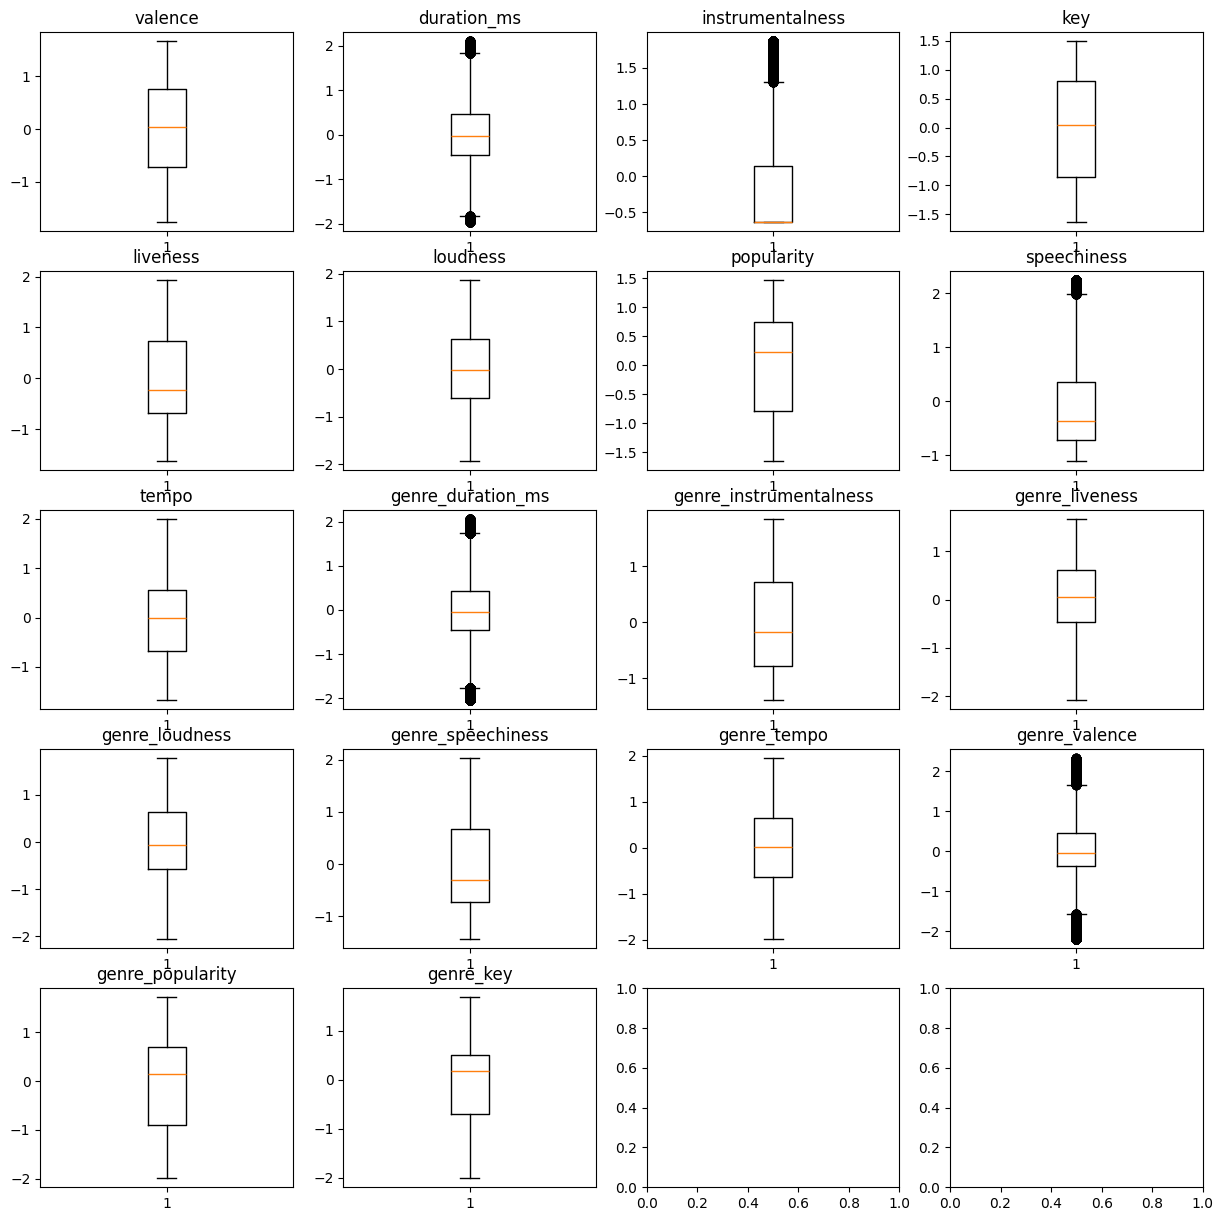

In [71]:
box_plot(main_data, numeric_features, n_rows=5, n_cols=4)

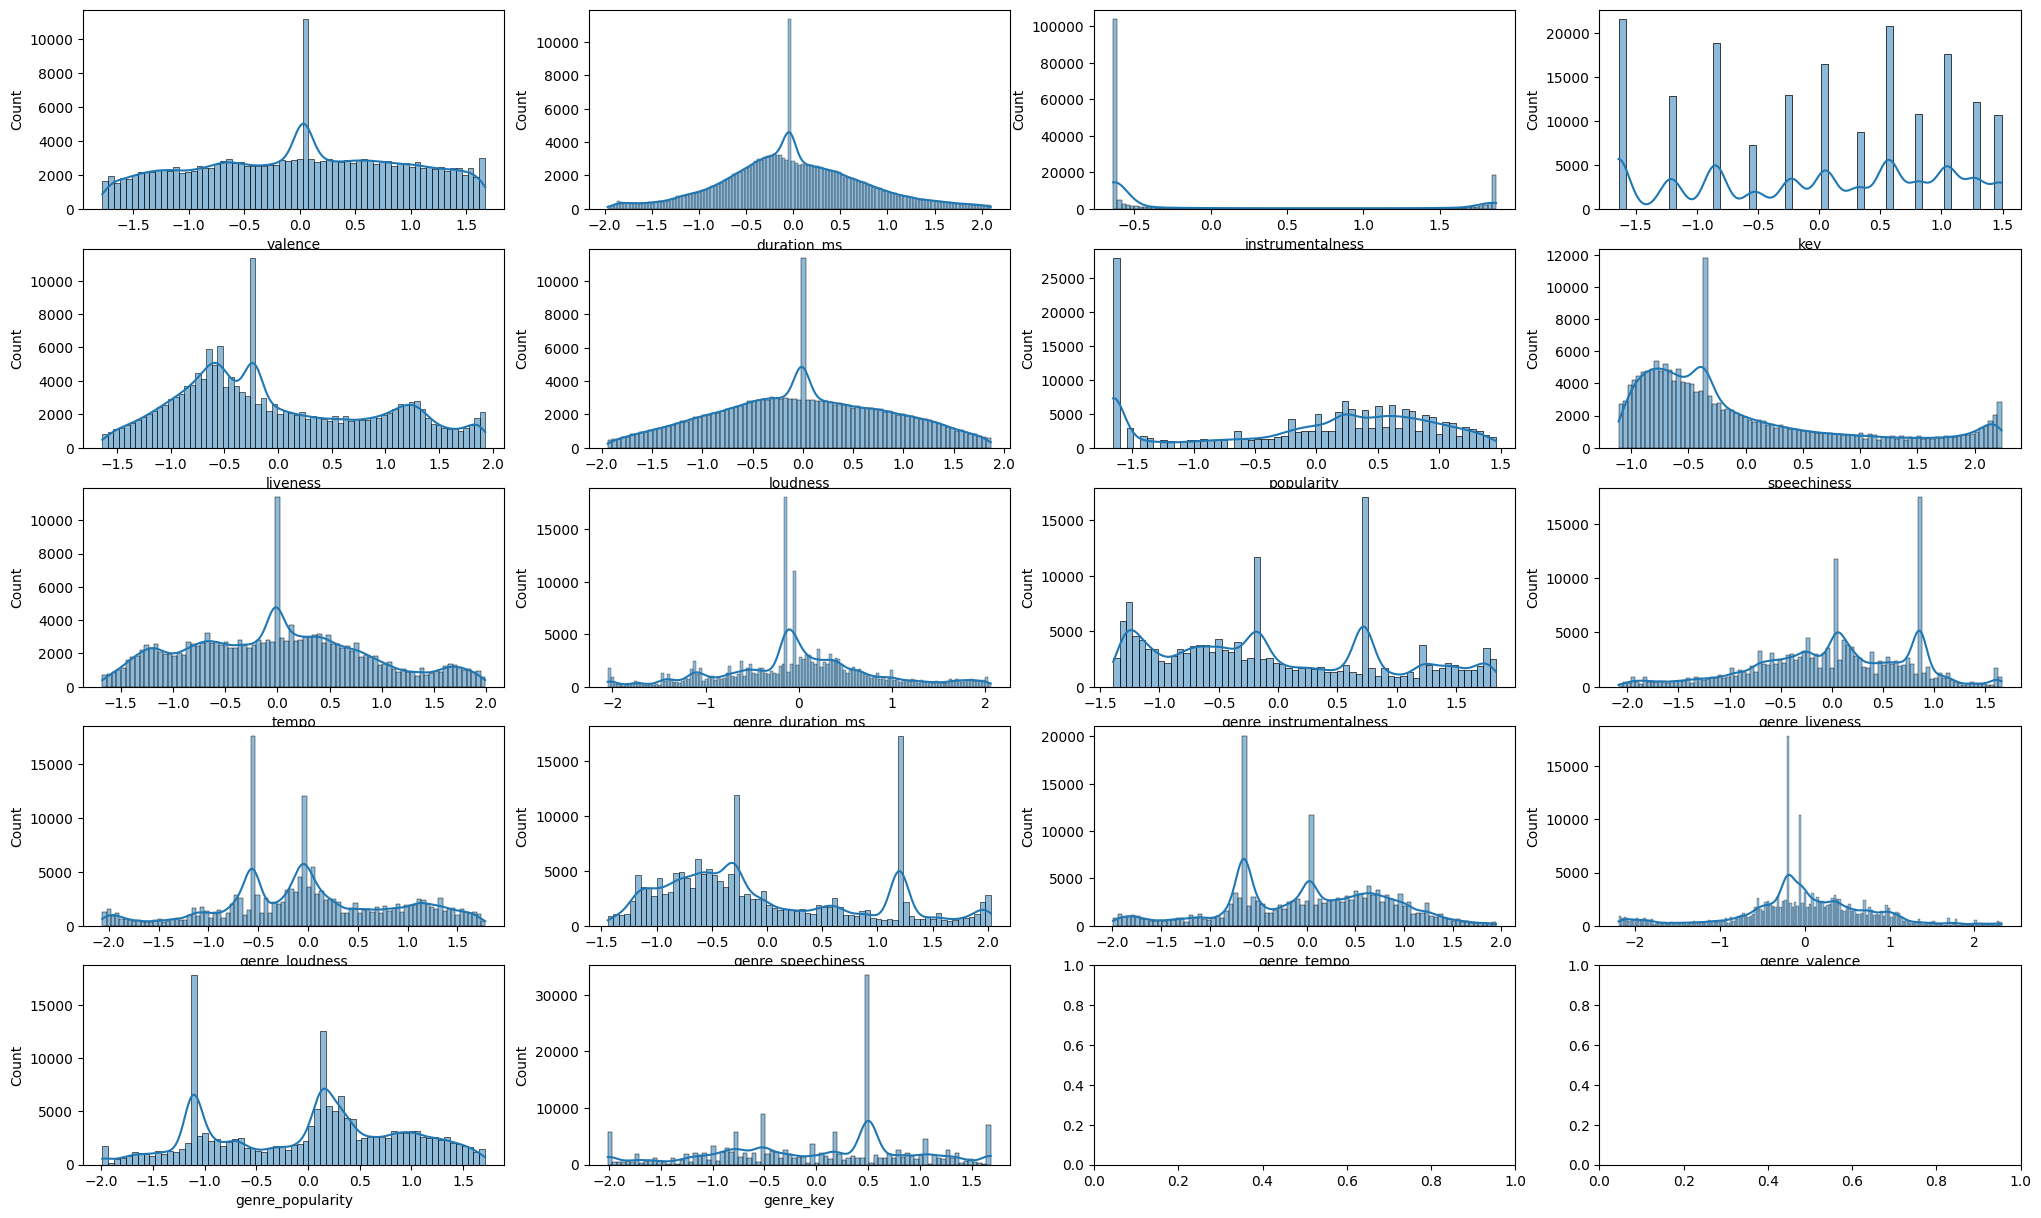

In [72]:
hist_plot(main_data, numeric_features, n_rows=5, n_cols=4)

Распределение данных улучшилось, однако полностью избавиться от выбросов не удалось

Выполним стандартизацию данных с помощью StandardScaler()

In [73]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(main_data[numeric_features])

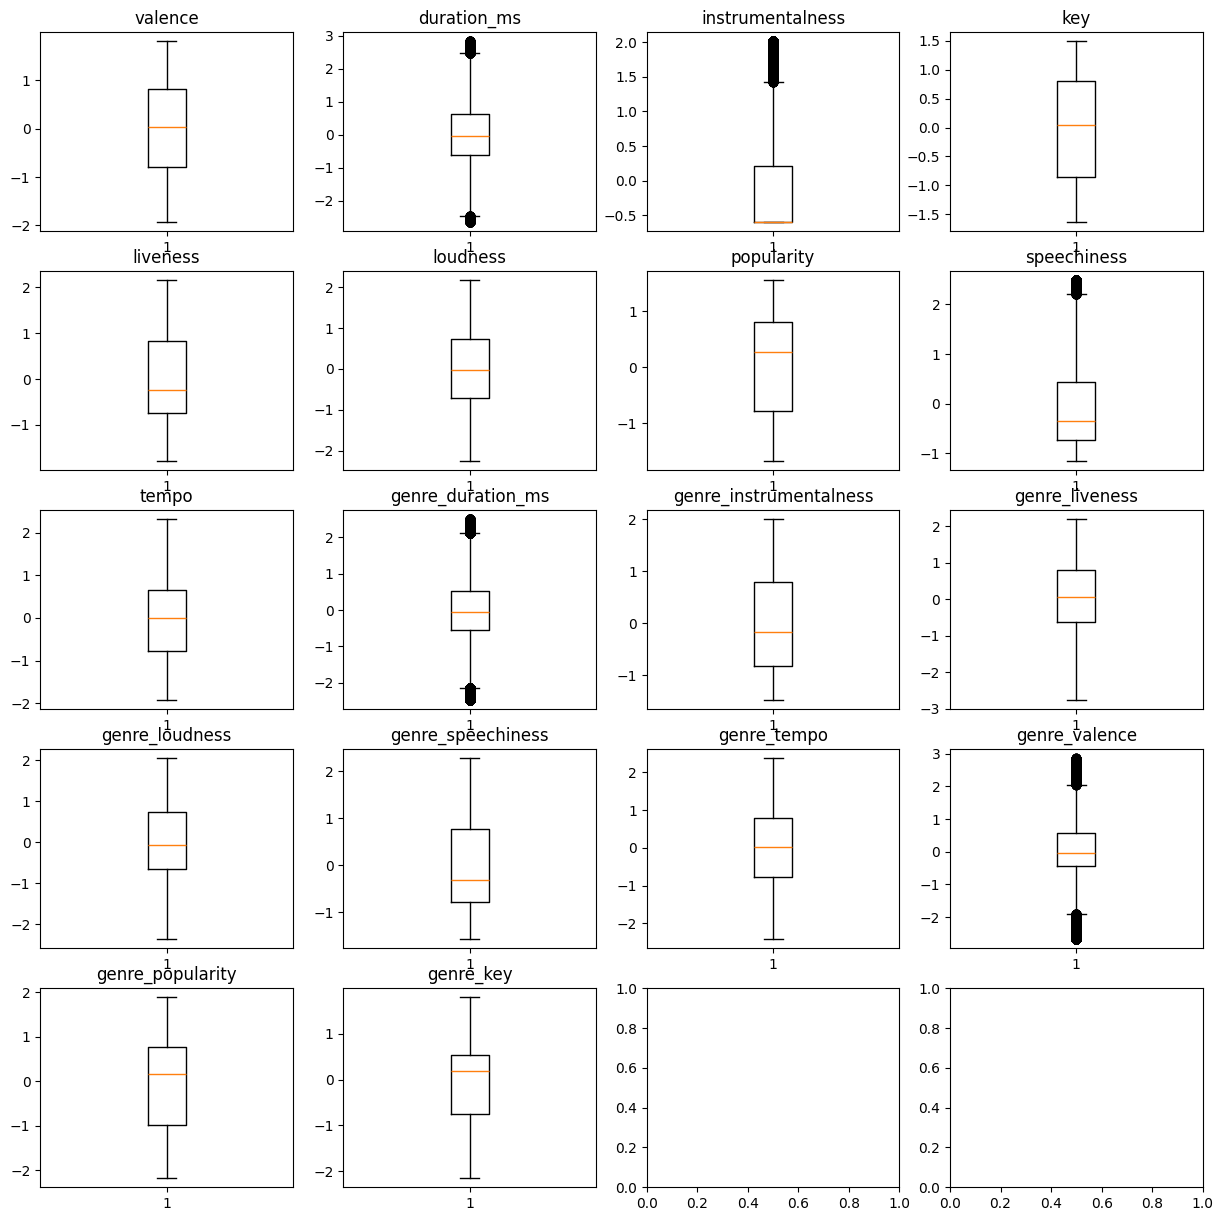

In [74]:
box_plot(pd.DataFrame(scaled_features, columns=numeric_features), numeric_features, n_rows=5, n_cols=4)

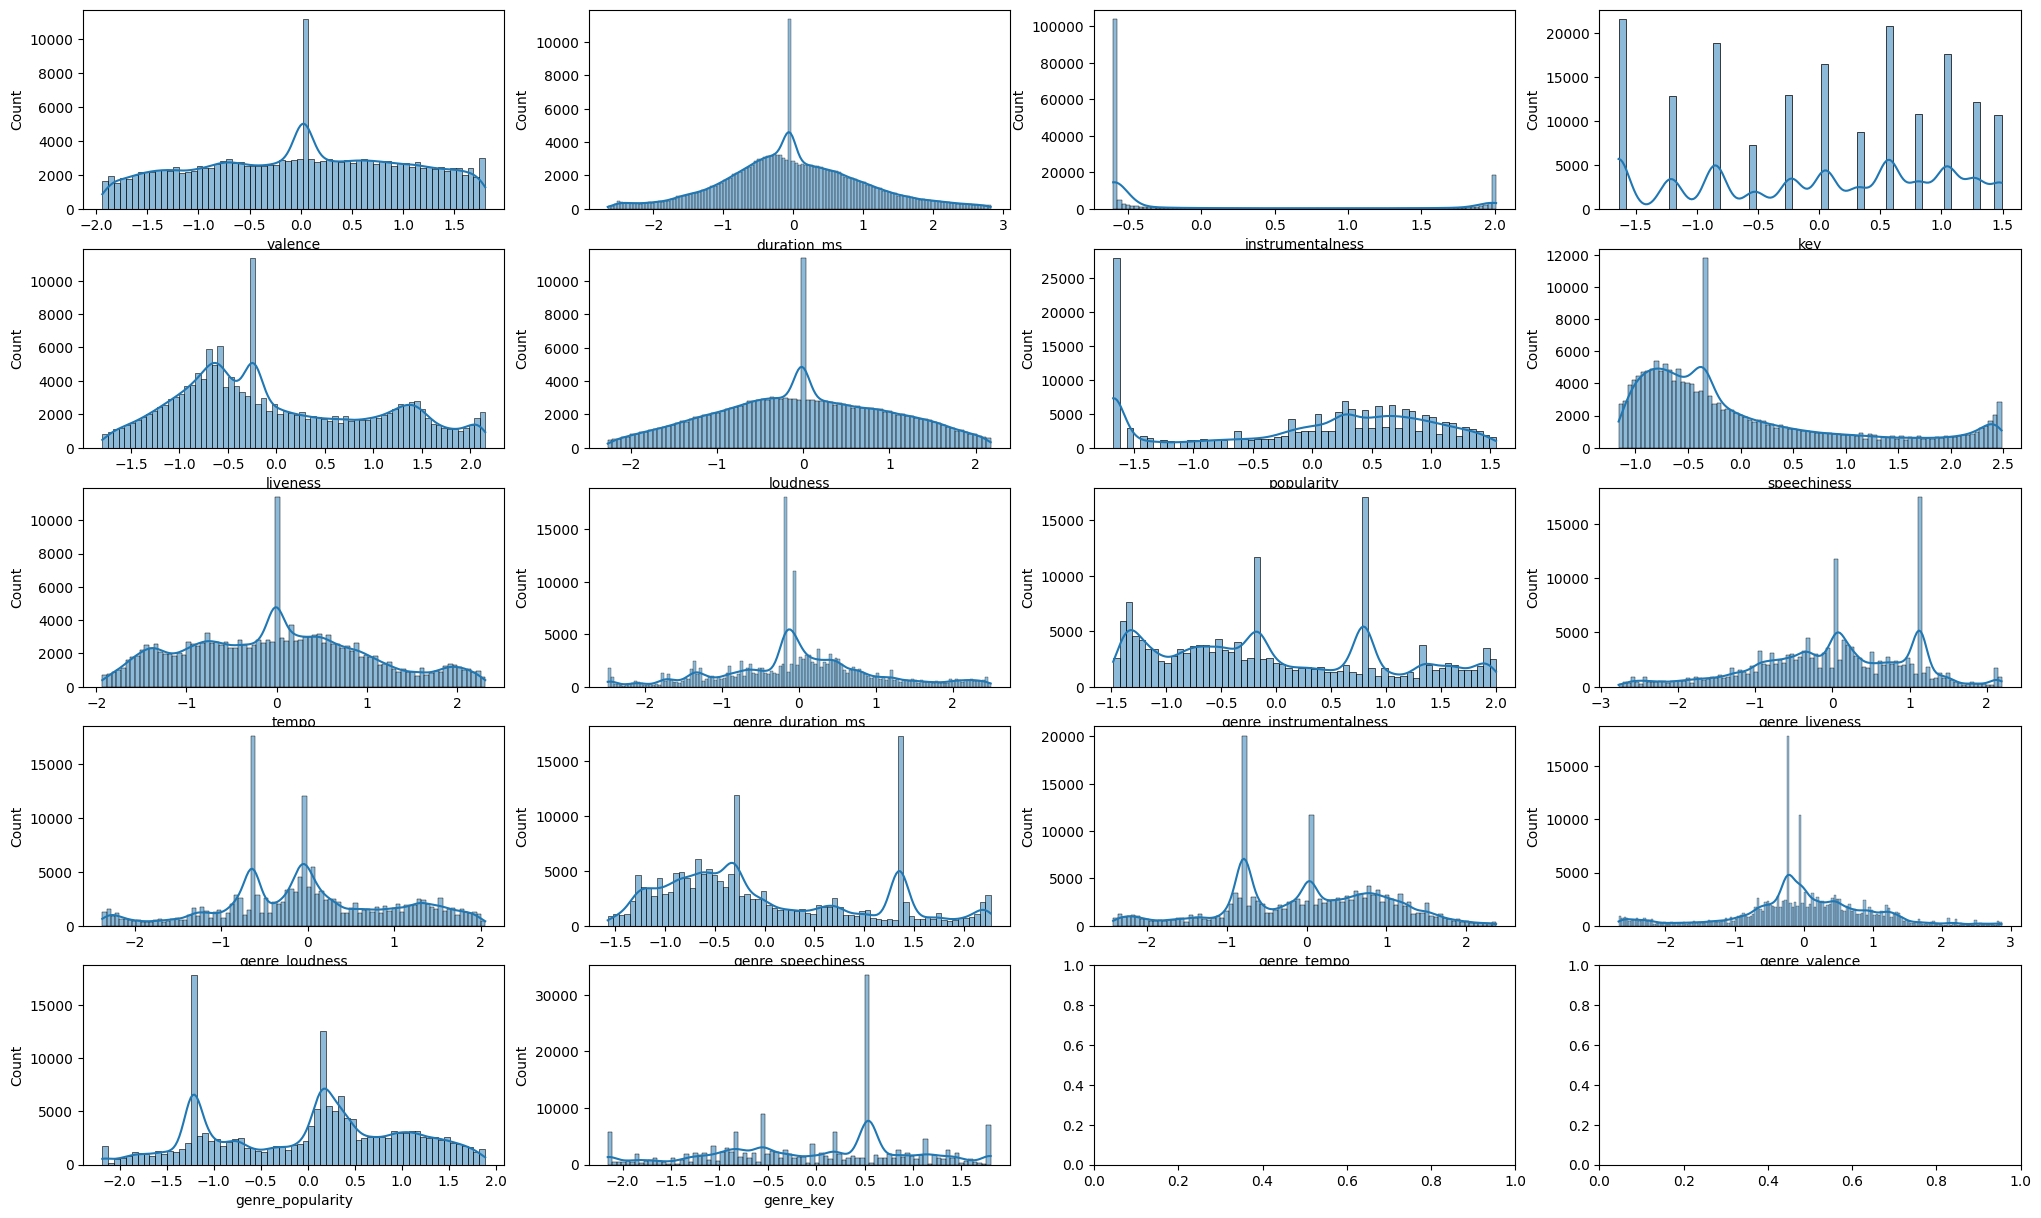

In [75]:
hist_plot(pd.DataFrame(scaled_features, columns=numeric_features), numeric_features, n_rows=5, n_cols=4)

Выполним предварительную кластеризацию датасета на всем наборе шкалированных числовых признаков (scaled_feature), предварительно снизив размерность с помощью PCA. Отмечаем снижение размерности с 18 признаков до 15 признаков при сохранении уровня предсказанной дисперсии более 95 %.

In [76]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
reduced_features = pca.fit_transform(scaled_features)

print(f"Исходное число признаков: {scaled_features.shape[1]}")
print(f"Число компонент после PCA: {reduced_features.shape[1]}")
print(f"Объясненная дисперсия: {np.sum(pca.explained_variance_ratio_)}")

Исходное число признаков: 18
Число компонент после PCA: 15
Объясненная дисперсия: 0.9611109525070314


Предварительную кластеризацию проведем методом KMeans на всем наборе числовых признаков. В качестве метрик оценки качества кластеризации будем использовать KMeans score, силуэтный коэффициент и метрику Дэвиса-Болдина

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans

km_scores = []
silhouette_scores = []
db_scores = []

for i in range(2, 12):
    km = KMeans(n_clusters=i, random_state=42).fit(reduced_features)
    preds = km.predict(reduced_features)
    kmeans_score = -km.score(reduced_features)
    silhouette = silhouette_score(reduced_features, preds)
    db = davies_bouldin_score(reduced_features, preds)

    print(f"Clusters: {i} | KMeans score: {kmeans_score:.2f} | Silhouette score: {silhouette:.3f} | Davies-Bouldin score: {db:.3f}")
    km_scores.append(kmeans_score)
    silhouette_scores.append(silhouette)
    db_scores.append(db)

Clusters: 2 | KMeans score: 2534431.55 | Silhouette score: 0.181 | Davies-Bouldin score: 1.982
Clusters: 3 | KMeans score: 2290923.86 | Silhouette score: 0.183 | Davies-Bouldin score: 1.870
Clusters: 4 | KMeans score: 2180579.10 | Silhouette score: 0.121 | Davies-Bouldin score: 2.361
Clusters: 5 | KMeans score: 2028366.52 | Silhouette score: 0.130 | Davies-Bouldin score: 2.358
Clusters: 6 | KMeans score: 1961091.11 | Silhouette score: 0.108 | Davies-Bouldin score: 2.348
Clusters: 7 | KMeans score: 1909464.24 | Silhouette score: 0.103 | Davies-Bouldin score: 2.421
Clusters: 8 | KMeans score: 1777766.32 | Silhouette score: 0.110 | Davies-Bouldin score: 2.220
Clusters: 9 | KMeans score: 1740742.26 | Silhouette score: 0.108 | Davies-Bouldin score: 2.248
Clusters: 10 | KMeans score: 1725206.22 | Silhouette score: 0.103 | Davies-Bouldin score: 2.328
Clusters: 11 | KMeans score: 1678584.73 | Silhouette score: 0.106 | Davies-Bouldin score: 2.277


Отмечаем, очень низкие значения метрик качества кластеризации в диапазоне количества кластеров до 2 до 11. Возможно, причиной является неприемлемый метод кластеризации (KMeans), либо неправильно подобранные параметры кластеризации/количество кластеров, либо неправильный набор признаков для кластеризации.

Попробуем выполнить ту же кластеризацию, но уже на жанровых признаках композиций. Отберем их на этапе шкалирования данных и снизим размерность.

In [77]:
genres_scaled_features = scaled_features[:, 9:]
genres_scaled_features.shape

(170653, 9)

In [78]:
pca_genres = PCA(n_components=0.95)
genres_reduced_features = pca_genres.fit_transform(genres_scaled_features)

print(f"Исходное число признаков: {genres_scaled_features.shape[1]}")
print(f"Число компонент после PCA: {genres_reduced_features.shape[1]}")
print(f"Объясненная дисперсия: {np.sum(pca_genres.explained_variance_ratio_)}")

Исходное число признаков: 9
Число компонент после PCA: 7
Объясненная дисперсия: 0.9562485020696339


Выполним кластеризацию на жанровых признаках методом KMeans, задавая число кластеров от 2 до 11.

In [ ]:
genres_km_scores = []
genres_silhouette_scores = []
genres_db_scores = []

for i in range(2, 12):
    genres_km = KMeans(n_clusters=i, random_state=42).fit(genres_reduced_features)
    genres_preds = genres_km.predict(genres_reduced_features)
    genres_kmeans_score = -genres_km.score(genres_reduced_features)
    genres_silhouette = silhouette_score(genres_reduced_features, genres_preds)
    genres_db = davies_bouldin_score(genres_reduced_features, genres_preds)

    print(f"Clusters: {i} | KMeans score: {genres_kmeans_score:.2f} | Silhouette score: {genres_silhouette:.3f} | Davies-Bouldin score: {genres_db:.3f}")
    genres_km_scores.append(genres_kmeans_score)
    genres_silhouette_scores.append(genres_silhouette)
    genres_db_scores.append(genres_db)

Clusters: 2 | KMeans score: 1045738.65 | Silhouette score: 0.297 | Davies-Bouldin score: 1.402
Clusters: 3 | KMeans score: 889587.88 | Silhouette score: 0.284 | Davies-Bouldin score: 1.491
Clusters: 4 | KMeans score: 820367.81 | Silhouette score: 0.226 | Davies-Bouldin score: 1.605
Clusters: 5 | KMeans score: 698929.78 | Silhouette score: 0.258 | Davies-Bouldin score: 1.452
Clusters: 6 | KMeans score: 552451.34 | Silhouette score: 0.288 | Davies-Bouldin score: 1.270
Clusters: 7 | KMeans score: 500011.53 | Silhouette score: 0.302 | Davies-Bouldin score: 1.179
Clusters: 8 | KMeans score: 464164.77 | Silhouette score: 0.300 | Davies-Bouldin score: 1.226
Clusters: 9 | KMeans score: 434391.06 | Silhouette score: 0.295 | Davies-Bouldin score: 1.244
Clusters: 10 | KMeans score: 418442.25 | Silhouette score: 0.288 | Davies-Bouldin score: 1.314
Clusters: 11 | KMeans score: 397797.49 | Silhouette score: 0.289 | Davies-Bouldin score: 1.292


Метрики качества кластеризации плохие.

Продолжим кластеризацию, но увеличив число предполагаемых кластеров до 30

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

km_scores = []
silhouette_scores = []
db_scores = []

for i in [2, 6, 10, 15, 20, 25, 30]:
    km = KMeans(n_clusters=i, random_state=42).fit(genres_reduced_features)
    preds = km.predict(genres_reduced_features)
    kmeans_score = -km.score(genres_reduced_features)
    silhouette = silhouette_score(genres_reduced_features, preds)
    db = davies_bouldin_score(genres_reduced_features, preds)

    print(f"Clusters: {i} | KMeans score: {kmeans_score:.2f} | Silhouette score: {silhouette:.3f} | Davies-Bouldin score: {db:.3f}")
    km_scores.append(kmeans_score)
    silhouette_scores.append(silhouette)
    db_scores.append(db)

Clusters: 2 | KMeans score: 1097777.48 | Silhouette score: 0.287 | Davies-Bouldin score: 1.460
Clusters: 6 | KMeans score: 726359.35 | Silhouette score: 0.256 | Davies-Bouldin score: 1.451
Clusters: 10 | KMeans score: 474488.10 | Silhouette score: 0.249 | Davies-Bouldin score: 1.295
Clusters: 15 | KMeans score: 388403.34 | Silhouette score: 0.271 | Davies-Bouldin score: 1.407
Clusters: 20 | KMeans score: 344969.27 | Silhouette score: 0.263 | Davies-Bouldin score: 1.425
Clusters: 25 | KMeans score: 310600.93 | Silhouette score: 0.270 | Davies-Bouldin score: 1.384
Clusters: 30 | KMeans score: 284982.51 | Silhouette score: 0.273 | Davies-Bouldin score: 1.397


Метрики кластеризации не улучшились. Еще увеличим предполагаемое количество кластеров до 500

In [ ]:
km_scores = []
silhouette_scores = []
db_scores = []

for i in [50, 100, 200, 500]:
    km = KMeans(n_clusters=i, random_state=42).fit(genres_reduced_features)
    preds = km.predict(genres_reduced_features)
    kmeans_score = -km.score(genres_reduced_features)
    silhouette = silhouette_score(genres_reduced_features, preds)
    db = davies_bouldin_score(genres_reduced_features, preds)

    print(f"Clusters: {i} | KMeans score: {kmeans_score:.2f} | Silhouette score: {silhouette:.3f} | Davies-Bouldin score: {db:.3f}")
    km_scores.append(kmeans_score)
    silhouette_scores.append(silhouette)
    db_scores.append(db)

Clusters: 50 | KMeans score: 218739.88 | Silhouette score: 0.302 | Davies-Bouldin score: 1.325
Clusters: 100 | KMeans score: 153594.77 | Silhouette score: 0.316 | Davies-Bouldin score: 1.312
Clusters: 200 | KMeans score: 103394.77 | Silhouette score: 0.358 | Davies-Bouldin score: 1.257
Clusters: 500 | KMeans score: 60032.89 | Silhouette score: 0.407 | Davies-Bouldin score: 1.159


Отмечаем, улучшение метрик кластеризации при увеличении предполагаемого количества кластеров с 50 до 500. Это наталкивает на мысль, что, возможно, изначально было выбрано слишком малое количество кластеров.

Выполним кластеризацию методом HDBSCAN. Но предварительно проведем подбор параметров "min_cluster_size", "min_samples", "alpha", "method" и "epsilon". Наша цель - подобрать такие параметры, чтобы снизить шум до минимально возможного уровня, сохранив приемлемым значение силуэтного коэффициента. Будем оптимизировать (добиваться минимального значения) выражение (noise_ratio - 0.3 * silhouette). Почему не просто noise_ratio? Потому что в таком случае optuna просто выбрала бы максимально возможное количество кластеров, что снизило бы до минимума шум. Но это не приемлемый для нас вариант. Нам необходимо добиться минимального шума при максимально высоком значении силуэтного коэффициента и приемлемом количестве кластеров (существенно меньше количества жанров композиций; их около 2970 штук).

In [172]:
import optuna
import hdbscan
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.utils import resample
from functools import partial

def objective(trial, min_silhouette=0.6, max_silhouette=1.0):

    params = {
        'min_cluster_size': trial.suggest_int("min_cluster_size", 35, 50),
        'min_samples': trial.suggest_int("min_samples", 2, 5),
        'alpha': trial.suggest_float("alpha", 0.5, 1.0),
        'method': trial.suggest_categorical("method", ["eom", "leaf"]),
        'epsilon': trial.suggest_float("epsilon", 0, 0.3)
    }

    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=params['min_cluster_size'],
        min_samples=params['min_samples'],
        alpha=params['alpha'],
        cluster_selection_method=params['method'],
        metric='euclidean',
        cluster_selection_epsilon=params['epsilon'],
        core_dist_n_jobs=-1
    ).fit(genres_reduced_features)

    labels = clusterer.labels_
    noise_ratio = np.clip((labels == -1).mean(), 0, 1)

    valid_labels = labels[labels != -1]
    n_clusters = len(np.unique(valid_labels))

    if n_clusters < 2:
        trial.set_user_attr("silhouette", 0.0)
        return 1.0

    sample_size = min(15000, len(valid_labels))
    sample_idx = resample(np.arange(len(genres_reduced_features)),
                         n_samples=sample_size,
                         replace=False,
                         random_state=42)

    X_sample = genres_reduced_features[sample_idx]
    labels_sample = labels[sample_idx]
    valid_mask = labels_sample != -1

    if sum(valid_mask) > 1 and len(np.unique(labels_sample[valid_mask])) > 1:
        silhouette = np.clip(
            silhouette_score(X_sample[valid_mask], labels_sample[valid_mask], metric="euclidean"),
            min_silhouette,
            max_silhouette
        )
    else:
        silhouette = min_silhouette

    trial.set_user_attr("silhouette", float(silhouette))
    trial.set_user_attr("noise_ratio", float(noise_ratio))
    trial.set_user_attr("n_clusters", int(n_clusters))

    print(f"\nИтерация {trial.number}:")
    print(f"Параметры: {params}")
    print(f"Шум: {noise_ratio:.1%}, Кластеров: {n_clusters}, Silhouette: {silhouette:.3f}")

    return max(0, noise_ratio) - 0.3 * silhouette

# Промежуточные результаты
def print_best_trial(study, trial):
    if study.best_trial.number == trial.number:
        print("\n Новый лучший результат ")
        print(f"Шум: {trial.user_attrs['noise_ratio']:.1%}")
        print(f"Silhouette: {trial.user_attrs['silhouette']:.3f}")
        print(f"Кластеров: {trial.user_attrs['n_clusters']}")
        print(f"Параметры: {trial.params}\n")

study = optuna.create_study(direction="minimize")
study.optimize(
    partial(objective, min_silhouette=0.6, max_silhouette=1.0),
    n_trials=30,
    n_jobs=-1,
    callbacks=[print_best_trial]
)

# Итоговые результаты
print("\n Лучшие параметры:")
print(study.best_params)
print(f"\n Итоговые метрики:")
print(f"Доля шума: {study.best_trial.user_attrs['noise_ratio']:.1%}")
print(f"Silhouette: {study.best_trial.user_attrs['silhouette']:.3f}")
print(f"Количество кластеров: {study.best_trial.user_attrs['n_clusters']}")

[I 2025-04-24 09:55:15,038] A new study created in memory with name: no-name-525601aa-644e-4382-a0ba-f4b7c71b1224
[I 2025-04-24 09:58:33,591] Trial 1 finished with value: 0.03707326357788765 and parameters: {'min_cluster_size': 38, 'min_samples': 3, 'alpha': 0.7396254387488836, 'method': 'leaf', 'epsilon': 0.07696369315010974}. Best is trial 1 with value: 0.03707326357788765.



Итерация 1:
Параметры: {'min_cluster_size': 38, 'min_samples': 3, 'alpha': 0.7396254387488836, 'method': 'leaf', 'epsilon': 0.07696369315010974}
Шум: 28.7%, Кластеров: 1123, Silhouette: 0.833

 Новый лучший результат 
Шум: 28.7%
Silhouette: 0.833
Кластеров: 1123
Параметры: {'min_cluster_size': 38, 'min_samples': 3, 'alpha': 0.7396254387488836, 'method': 'leaf', 'epsilon': 0.07696369315010974}



[I 2025-04-24 09:58:34,316] Trial 0 finished with value: 0.08021911258388173 and parameters: {'min_cluster_size': 50, 'min_samples': 5, 'alpha': 0.6380827589454039, 'method': 'eom', 'epsilon': 0.14894972760242123}. Best is trial 1 with value: 0.03707326357788765.



Итерация 0:
Параметры: {'min_cluster_size': 50, 'min_samples': 5, 'alpha': 0.6380827589454039, 'method': 'eom', 'epsilon': 0.14894972760242123}
Шум: 31.3%, Кластеров: 815, Silhouette: 0.775


[I 2025-04-24 10:01:14,402] Trial 2 finished with value: 0.07438275492057739 and parameters: {'min_cluster_size': 47, 'min_samples': 5, 'alpha': 0.5491600460005472, 'method': 'leaf', 'epsilon': 0.036168463281346715}. Best is trial 1 with value: 0.03707326357788765.



Итерация 2:
Параметры: {'min_cluster_size': 47, 'min_samples': 5, 'alpha': 0.5491600460005472, 'method': 'leaf', 'epsilon': 0.036168463281346715}
Шум: 32.2%, Кластеров: 906, Silhouette: 0.825


[I 2025-04-24 10:01:16,709] Trial 3 finished with value: 0.024600240214216973 and parameters: {'min_cluster_size': 35, 'min_samples': 5, 'alpha': 0.9780750790435215, 'method': 'eom', 'epsilon': 0.09185934611263305}. Best is trial 3 with value: 0.024600240214216973.



Итерация 3:
Параметры: {'min_cluster_size': 35, 'min_samples': 5, 'alpha': 0.9780750790435215, 'method': 'eom', 'epsilon': 0.09185934611263305}
Шум: 27.6%, Кластеров: 1193, Silhouette: 0.839

 Новый лучший результат 
Шум: 27.6%
Silhouette: 0.839
Кластеров: 1193
Параметры: {'min_cluster_size': 35, 'min_samples': 5, 'alpha': 0.9780750790435215, 'method': 'eom', 'epsilon': 0.09185934611263305}



[I 2025-04-24 10:04:13,690] Trial 4 finished with value: 0.06508299430747705 and parameters: {'min_cluster_size': 42, 'min_samples': 3, 'alpha': 0.7608064384955296, 'method': 'leaf', 'epsilon': 0.2670494131934171}. Best is trial 3 with value: 0.024600240214216973.



Итерация 4:
Параметры: {'min_cluster_size': 42, 'min_samples': 3, 'alpha': 0.7608064384955296, 'method': 'leaf', 'epsilon': 0.2670494131934171}
Шум: 24.7%, Кластеров: 815, Silhouette: 0.605


[I 2025-04-24 10:04:15,025] Trial 5 finished with value: 0.04221251819835137 and parameters: {'min_cluster_size': 40, 'min_samples': 4, 'alpha': 0.8255177738129581, 'method': 'eom', 'epsilon': 0.004911556166621989}. Best is trial 3 with value: 0.024600240214216973.



Итерация 5:
Параметры: {'min_cluster_size': 40, 'min_samples': 4, 'alpha': 0.8255177738129581, 'method': 'eom', 'epsilon': 0.004911556166621989}
Шум: 29.1%, Кластеров: 1064, Silhouette: 0.830


[I 2025-04-24 10:07:10,841] Trial 6 finished with value: 0.07365065073784646 and parameters: {'min_cluster_size': 47, 'min_samples': 5, 'alpha': 0.782546391527162, 'method': 'eom', 'epsilon': 0.23941000512068322}. Best is trial 3 with value: 0.024600240214216973.



Итерация 6:
Параметры: {'min_cluster_size': 47, 'min_samples': 5, 'alpha': 0.782546391527162, 'method': 'eom', 'epsilon': 0.23941000512068322}
Шум: 27.5%, Кластеров: 755, Silhouette: 0.670


[I 2025-04-24 10:07:11,792] Trial 7 finished with value: 0.032153708982516016 and parameters: {'min_cluster_size': 37, 'min_samples': 2, 'alpha': 0.7185352011964227, 'method': 'eom', 'epsilon': 0.06733676394815193}. Best is trial 3 with value: 0.024600240214216973.



Итерация 7:
Параметры: {'min_cluster_size': 37, 'min_samples': 2, 'alpha': 0.7185352011964227, 'method': 'eom', 'epsilon': 0.06733676394815193}
Шум: 28.1%, Кластеров: 1146, Silhouette: 0.831


[I 2025-04-24 10:10:30,037] Trial 8 finished with value: 0.08517553163436914 and parameters: {'min_cluster_size': 48, 'min_samples': 5, 'alpha': 0.8603170294863867, 'method': 'leaf', 'epsilon': 0.2781022175397374}. Best is trial 3 with value: 0.024600240214216973.



Итерация 8:
Параметры: {'min_cluster_size': 48, 'min_samples': 5, 'alpha': 0.8603170294863867, 'method': 'leaf', 'epsilon': 0.2781022175397374}
Шум: 26.5%, Кластеров: 678, Silhouette: 0.600


[I 2025-04-24 10:10:33,140] Trial 9 finished with value: 0.032130354484610324 and parameters: {'min_cluster_size': 37, 'min_samples': 2, 'alpha': 0.8319720793678489, 'method': 'eom', 'epsilon': 0.0035892468429633336}. Best is trial 3 with value: 0.024600240214216973.



Итерация 9:
Параметры: {'min_cluster_size': 37, 'min_samples': 2, 'alpha': 0.8319720793678489, 'method': 'eom', 'epsilon': 0.0035892468429633336}
Шум: 28.2%, Кластеров: 1150, Silhouette: 0.833


[I 2025-04-24 10:13:09,678] Trial 10 finished with value: 0.04884494005007792 and parameters: {'min_cluster_size': 42, 'min_samples': 2, 'alpha': 0.8856422011507294, 'method': 'eom', 'epsilon': 0.04325427976289401}. Best is trial 3 with value: 0.024600240214216973.



Итерация 10:
Параметры: {'min_cluster_size': 42, 'min_samples': 2, 'alpha': 0.8856422011507294, 'method': 'eom', 'epsilon': 0.04325427976289401}
Шум: 29.5%, Кластеров: 1030, Silhouette: 0.820


[I 2025-04-24 10:13:12,136] Trial 11 finished with value: 0.02467053343564185 and parameters: {'min_cluster_size': 35, 'min_samples': 4, 'alpha': 0.9681498261162597, 'method': 'eom', 'epsilon': 0.15066157628795104}. Best is trial 3 with value: 0.024600240214216973.



Итерация 11:
Параметры: {'min_cluster_size': 35, 'min_samples': 4, 'alpha': 0.9681498261162597, 'method': 'eom', 'epsilon': 0.15066157628795104}
Шум: 26.4%, Кластеров: 1150, Silhouette: 0.798


[I 2025-04-24 10:15:52,988] Trial 12 finished with value: 0.023907659762019473 and parameters: {'min_cluster_size': 35, 'min_samples': 4, 'alpha': 0.9950864516271135, 'method': 'eom', 'epsilon': 0.13206238301944595}. Best is trial 12 with value: 0.023907659762019473.



Итерация 12:
Параметры: {'min_cluster_size': 35, 'min_samples': 4, 'alpha': 0.9950864516271135, 'method': 'eom', 'epsilon': 0.13206238301944595}
Шум: 26.7%, Кластеров: 1167, Silhouette: 0.809

 Новый лучший результат 
Шум: 26.7%
Silhouette: 0.809
Кластеров: 1167
Параметры: {'min_cluster_size': 35, 'min_samples': 4, 'alpha': 0.9950864516271135, 'method': 'eom', 'epsilon': 0.13206238301944595}



[I 2025-04-24 10:15:54,417] Trial 13 finished with value: 0.024979206113398655 and parameters: {'min_cluster_size': 35, 'min_samples': 4, 'alpha': 0.9991676794711817, 'method': 'eom', 'epsilon': 0.1471489870842831}. Best is trial 12 with value: 0.023907659762019473.



Итерация 13:
Параметры: {'min_cluster_size': 35, 'min_samples': 4, 'alpha': 0.9991676794711817, 'method': 'eom', 'epsilon': 0.1471489870842831}
Шум: 26.5%, Кластеров: 1151, Silhouette: 0.799


[I 2025-04-24 10:18:35,485] Trial 15 finished with value: 0.0404082467756392 and parameters: {'min_cluster_size': 39, 'min_samples': 4, 'alpha': 0.9277779166115048, 'method': 'eom', 'epsilon': 0.11635881491669085}. Best is trial 12 with value: 0.023907659762019473.



Итерация 15:
Параметры: {'min_cluster_size': 39, 'min_samples': 4, 'alpha': 0.9277779166115048, 'method': 'eom', 'epsilon': 0.11635881491669085}
Шум: 28.2%, Кластеров: 1064, Silhouette: 0.805


[I 2025-04-24 10:18:36,575] Trial 14 finished with value: 0.02458864497491209 and parameters: {'min_cluster_size': 35, 'min_samples': 4, 'alpha': 0.9882054089862973, 'method': 'eom', 'epsilon': 0.1359192183679345}. Best is trial 12 with value: 0.023907659762019473.



Итерация 14:
Параметры: {'min_cluster_size': 35, 'min_samples': 4, 'alpha': 0.9882054089862973, 'method': 'eom', 'epsilon': 0.1359192183679345}
Шум: 26.6%, Кластеров: 1162, Silhouette: 0.806


[I 2025-04-24 10:21:14,972] Trial 17 finished with value: 0.056774089372583325 and parameters: {'min_cluster_size': 44, 'min_samples': 3, 'alpha': 0.9149234030120785, 'method': 'eom', 'epsilon': 0.1966078664977483}. Best is trial 12 with value: 0.023907659762019473.



Итерация 17:
Параметры: {'min_cluster_size': 44, 'min_samples': 3, 'alpha': 0.9149234030120785, 'method': 'eom', 'epsilon': 0.1966078664977483}
Шум: 27.8%, Кластеров: 885, Silhouette: 0.736


[I 2025-04-24 10:21:17,909] Trial 16 finished with value: 0.029585155137003882 and parameters: {'min_cluster_size': 35, 'min_samples': 3, 'alpha': 0.9315029235589566, 'method': 'eom', 'epsilon': 0.20805284569013263}. Best is trial 12 with value: 0.023907659762019473.



Итерация 16:
Параметры: {'min_cluster_size': 35, 'min_samples': 3, 'alpha': 0.9315029235589566, 'method': 'eom', 'epsilon': 0.20805284569013263}
Шум: 24.6%, Кластеров: 1057, Silhouette: 0.721


[I 2025-04-24 10:24:07,175] Trial 18 finished with value: 0.043875342349893515 and parameters: {'min_cluster_size': 40, 'min_samples': 4, 'alpha': 0.6730570681966501, 'method': 'eom', 'epsilon': 0.17949534844102183}. Best is trial 12 with value: 0.023907659762019473.



Итерация 18:
Параметры: {'min_cluster_size': 40, 'min_samples': 4, 'alpha': 0.6730570681966501, 'method': 'eom', 'epsilon': 0.17949534844102183}
Шум: 27.2%, Кластеров: 980, Silhouette: 0.759


[I 2025-04-24 10:24:07,877] Trial 19 finished with value: 0.04745858344058962 and parameters: {'min_cluster_size': 40, 'min_samples': 4, 'alpha': 0.6455942610593943, 'method': 'leaf', 'epsilon': 0.1978769865885512}. Best is trial 12 with value: 0.023907659762019473.



Итерация 19:
Параметры: {'min_cluster_size': 40, 'min_samples': 4, 'alpha': 0.6455942610593943, 'method': 'leaf', 'epsilon': 0.1978769865885512}
Шум: 27.1%, Кластеров: 959, Silhouette: 0.744


[I 2025-04-24 10:26:44,577] Trial 20 finished with value: 0.06139854966400274 and parameters: {'min_cluster_size': 44, 'min_samples': 4, 'alpha': 0.5556622210747504, 'method': 'leaf', 'epsilon': 0.11488123246141904}. Best is trial 12 with value: 0.023907659762019473.



Итерация 20:
Параметры: {'min_cluster_size': 44, 'min_samples': 4, 'alpha': 0.5556622210747504, 'method': 'leaf', 'epsilon': 0.11488123246141904}
Шум: 30.3%, Кластеров: 967, Silhouette: 0.807


[I 2025-04-24 10:26:46,032] Trial 21 finished with value: 0.03458431236242859 and parameters: {'min_cluster_size': 37, 'min_samples': 3, 'alpha': 0.5262895020494807, 'method': 'eom', 'epsilon': 0.11987938662731637}. Best is trial 12 with value: 0.023907659762019473.



Итерация 21:
Параметры: {'min_cluster_size': 37, 'min_samples': 3, 'alpha': 0.5262895020494807, 'method': 'eom', 'epsilon': 0.11987938662731637}
Шум: 27.7%, Кластеров: 1117, Silhouette: 0.806


[I 2025-04-24 10:29:26,241] Trial 22 finished with value: 0.035506001948636456 and parameters: {'min_cluster_size': 37, 'min_samples': 5, 'alpha': 0.9996973742671722, 'method': 'eom', 'epsilon': 0.10605172302369303}. Best is trial 12 with value: 0.023907659762019473.



Итерация 22:
Параметры: {'min_cluster_size': 37, 'min_samples': 5, 'alpha': 0.9996973742671722, 'method': 'eom', 'epsilon': 0.10605172302369303}
Шум: 28.2%, Кластеров: 1121, Silhouette: 0.822


[I 2025-04-24 10:29:27,459] Trial 23 finished with value: 0.029735837813496646 and parameters: {'min_cluster_size': 36, 'min_samples': 5, 'alpha': 0.9880522054678819, 'method': 'eom', 'epsilon': 0.08956245082599487}. Best is trial 12 with value: 0.023907659762019473.



Итерация 23:
Параметры: {'min_cluster_size': 36, 'min_samples': 5, 'alpha': 0.9880522054678819, 'method': 'eom', 'epsilon': 0.08956245082599487}
Шум: 28.1%, Кластеров: 1164, Silhouette: 0.838


[I 2025-04-24 10:32:05,067] Trial 25 finished with value: 0.025923105621147413 and parameters: {'min_cluster_size': 35, 'min_samples': 4, 'alpha': 0.9486907881742402, 'method': 'eom', 'epsilon': 0.1667388920334593}. Best is trial 12 with value: 0.023907659762019473.



Итерация 25:
Параметры: {'min_cluster_size': 35, 'min_samples': 4, 'alpha': 0.9486907881742402, 'method': 'eom', 'epsilon': 0.1667388920334593}
Шум: 26.0%, Кластеров: 1131, Silhouette: 0.781


[I 2025-04-24 10:32:06,875] Trial 24 finished with value: 0.02414497638722507 and parameters: {'min_cluster_size': 35, 'min_samples': 5, 'alpha': 0.9596405255282435, 'method': 'eom', 'epsilon': 0.07353166960316275}. Best is trial 12 with value: 0.023907659762019473.



Итерация 24:
Параметры: {'min_cluster_size': 35, 'min_samples': 5, 'alpha': 0.9596405255282435, 'method': 'eom', 'epsilon': 0.07353166960316275}
Шум: 27.8%, Кластеров: 1202, Silhouette: 0.846


[I 2025-04-24 10:34:47,337] Trial 26 finished with value: 0.03679287049164348 and parameters: {'min_cluster_size': 38, 'min_samples': 5, 'alpha': 0.8910370246398434, 'method': 'eom', 'epsilon': 0.05309414188543899}. Best is trial 12 with value: 0.023907659762019473.



Итерация 26:
Параметры: {'min_cluster_size': 38, 'min_samples': 5, 'alpha': 0.8910370246398434, 'method': 'eom', 'epsilon': 0.05309414188543899}
Шум: 28.8%, Кластеров: 1115, Silhouette: 0.839


[I 2025-04-24 10:34:48,463] Trial 27 finished with value: 0.03542626436949037 and parameters: {'min_cluster_size': 38, 'min_samples': 4, 'alpha': 0.872626909023859, 'method': 'eom', 'epsilon': 0.05812096464800591}. Best is trial 12 with value: 0.023907659762019473.



Итерация 27:
Параметры: {'min_cluster_size': 38, 'min_samples': 4, 'alpha': 0.872626909023859, 'method': 'eom', 'epsilon': 0.05812096464800591}
Шум: 28.6%, Кластеров: 1115, Silhouette: 0.835


[I 2025-04-24 10:37:25,957] Trial 28 finished with value: 0.029816170182061147 and parameters: {'min_cluster_size': 36, 'min_samples': 4, 'alpha': 0.9007136404651948, 'method': 'eom', 'epsilon': 0.13125528653613547}. Best is trial 12 with value: 0.023907659762019473.



Итерация 28:
Параметры: {'min_cluster_size': 36, 'min_samples': 4, 'alpha': 0.9007136404651948, 'method': 'eom', 'epsilon': 0.13125528653613547}
Шум: 27.2%, Кластеров: 1134, Silhouette: 0.808


[I 2025-04-24 10:37:26,173] Trial 29 finished with value: 0.029816170182061147 and parameters: {'min_cluster_size': 36, 'min_samples': 4, 'alpha': 0.9405769213953976, 'method': 'eom', 'epsilon': 0.13233441699358903}. Best is trial 12 with value: 0.023907659762019473.



Итерация 29:
Параметры: {'min_cluster_size': 36, 'min_samples': 4, 'alpha': 0.9405769213953976, 'method': 'eom', 'epsilon': 0.13233441699358903}
Шум: 27.2%, Кластеров: 1134, Silhouette: 0.808

 Лучшие параметры:
{'min_cluster_size': 35, 'min_samples': 4, 'alpha': 0.9950864516271135, 'method': 'eom', 'epsilon': 0.13206238301944595}

 Итоговые метрики:
Доля шума: 26.7%
Silhouette: 0.809
Количество кластеров: 1167


Проведенная выше подборка параметров для кластеризации с помощью HDBSCAN из-за небольшого количества итераций (30) не является идеальной и окончательной. Анализ полученных значений шума и силуэтного коэффициента показывает, что снижение "min_cluster_size" (до 35) и "min_samples" (до 2) (хотя это приводит к мелким и разреженным кластерам, однако позволяет кластеризовать редкие композиции, трудно относимые к крупным кластерам, и, тем самым, снизить шум до более или менее приемлемого уровня). Поэтому для кластеризации с помощью HDBSCAN выберем следующие показатели: "min_cluster_size" = 35 и "min_samples" = 2, alpha = 0.78, cluster_selection_epsilon = 0.3. При кластеризации, кроме силуэтного коэффициента и оценки Калински-Харабаша, в качестве метрики используется величина уверенности в отнесении метки к любому классу, кроме шума. Эта метрика показывает, наскольку мы уверены в результатах кластеризации.

In [79]:
import hdbscan
from sklearn.metrics import silhouette_score, calinski_harabasz_score

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=35,
    min_samples=2,
    cluster_selection_method='eom',
    metric='euclidean',
    core_dist_n_jobs=-1,
    alpha=0.78,
    cluster_selection_epsilon=0.3,
).fit(genres_reduced_features)

labels = clusterer.labels_
valid_mask = labels != -1
n_clusters = len(np.unique(labels[valid_mask]))

print(
    f"Кластеров: {n_clusters}\n"
    f"Доля шума: {(labels == -1).mean():.1%}\n"
    f"Silhouette Score: {silhouette_score(genres_scaled_features[valid_mask], labels[valid_mask]):.3f}\n"
    f"Calinski-Harabasz: {calinski_harabasz_score(genres_scaled_features[valid_mask], labels[valid_mask]):.1f}\n"
    f"Средняя уверенность: {clusterer.probabilities_[valid_mask].mean():.3f}"
)

Кластеров: 870
Доля шума: 21.6%
Silhouette Score: 0.561
Calinski-Harabasz: 6040.2
Средняя уверенность: 0.949


Создадим в основном датасете новый столбец "cluster_hdbscan", в котором сохраним полученные метки классов.

In [80]:
main_data["cluster_hdbscan"] = labels

Затем проведем нормализацию характеристик композиций (не жанровых характеристик, а именно характеристик композиций). Несмотря на то, что мы уже выполнили логарифмическое преобразование (устраняет асимметрию данных) и стандартизацию (Standardscaler, приводит данные к одному масштабу), для расчета косинусного расстояния, что планируется в дальнейшем для формирования рекомендаций в рамках кластерах композиций, полезно выполнить нормализацию данных, что улучшит оценку косинусного расстояния. При этом нормализацию следует проводить в рамках каждого класса по отдельности. Проведем нормализацию на каждом кластере для шкалированных характеристик композиций.

In [81]:
from sklearn.preprocessing import Normalizer
import pandas as pd

normalised_features = pd.DataFrame(index=main_data.index, columns=range(scaled_features[:, :9].shape[1]))

normalizer = Normalizer()

for cluster_id in np.unique(main_data["cluster_hdbscan"]):

    cluster_mask = main_data["cluster_hdbscan"] == cluster_id
    cluster_data = scaled_features[:, :9][cluster_mask]

    normalised_features.loc[cluster_mask] = normalizer.fit_transform(cluster_data)

for i in range(scaled_features[:, :9].shape[1]):
     main_data[f"norm_feature_{i}"] = normalised_features[i]

In [82]:
main_data.head()

song_id   valence                                            artists  \
0        0 -1.757488  [Sergei Rachmaninoff, James Levine, Berliner P...   
1        1  0.031469                                       [Dennis Day]   
2        2  0.031469  [KHP Kridhamardawa Karaton Ngayogyakarta Hadin...   
3        3 -1.372494                                     [Frank Parker]   
4        4 -1.047957                                       [Phil Regan]   

   duration_ms  instrumentalness       key  liveness  loudness  \
0    -0.039565          1.862237  1.271436  1.869899 -1.412268   
1    -0.370385         -0.637732  0.568386  0.046501 -0.342040   
2     2.075672          1.866039 -0.526580 -0.707820 -0.720875   
3    -0.010650         -0.637244  0.051108  1.380548  0.237291   
4    -0.559703         -0.637703 -0.526580  0.648214  0.081151   

                                                name  popularity  ...  \
0  Piano Concerto No. 3 in D Minor, Op. 30: III. ...   -1.247561  ...   
1                            Clancy Lowered the Boom   -1.170322  ...   
2                                          Gati Bali   -1.170322  ...   
3                                          Danny Boy   -1.330909  ...   
4                        When Irish Eyes Are Smiling   -1.422619  ...   

   cluster_hdbscan  norm_feature_0  norm_feature_1  norm_feature_2  \
0               -1       -0.424699        -0.01174        0.444282   
1              617        0.008591       -0.171553       -0.206563   
2              617        0.006341        0.710253        0.509606   
3              617       -0.537483       -0.005014       -0.215361   
4              617       -0.475615       -0.312993       -0.249316   

   norm_feature_3  norm_feature_4  norm_feature_5  norm_feature_6  \
0        0.281812        0.462402       -0.365699       -0.278135   
1        0.195394        0.023246        -0.13815       -0.403903   
2       -0.133613       -0.194729       -0.214063       -0.298123   
3        0.018333        0.554021        0.098186       -0.481066   
4         -0.2185        0.304458        0.038023       -0.595843   

   norm_feature_7  norm_feature_8  
0       -0.154995       -0.306193  
1        0.840755       -0.004105  
2       -0.207959       -0.045644  
3       -0.269811       -0.208728  
4       -0.265047       -0.215652  

[5 rows x 31 columns]

### **3. Анализ пользовательских взаимодействий и генерация рекомендаций на их основе**

После того, как был подготовлен основной датасет и выполнена кластеризация на основе жанровых характеристик композиций, сформируем на базе основного датасета пользовательский датасет, содержащий 300 композиций (по 30 композиций для n=10 пользователей). Этот датасет будет служить в качестве валидационной выборки для оценки качества рекомендательной системы. Поскольку пользовательский датасет подготовлен на базе основного датасета, данные в нем уже подготовлены и шкалированы и не требуют дополнительной предобработки.

In [83]:
users_preference_data = UsersPreferences(data=main_data, users_dict=users_dict)
users_preference_data = users_preference_data.make_users_preference_df()

In [84]:
users_preference_data.head()

user_ID      user_name  song_id   valence  \
17493        1  Дмитрий Навой    17493  1.045469   
17732        1  Дмитрий Навой    17732 -0.973752   
50266        1  Дмитрий Навой    50266  0.031469   
50803        1  Дмитрий Навой    50803  0.023844   
52028        1  Дмитрий Навой    52028  1.664710   

                              artists  duration_ms  instrumentalness  \
17493  [Jay Sean, Sean Paul, Lil Jon]    -0.007169         -0.637732   
17732           [Angus & Julia Stone]     0.299493         -0.508461   
50266               [John Mellencamp]    -0.398257          0.684516   
50803   [Cherrelle, Alexander O'Neal]     0.260008         -0.637732   
52028                  [Bill Withers]     0.190796         -0.613553   

            key  liveness  loudness  ... cluster_hdbscan  norm_feature_0  \
17493  1.491353 -0.692591  1.355094  ...             869        0.365909   
17732  1.271436 -0.302781  0.379538  ...              -1       -0.415945   
50266  0.051108 -0.744765 -0.011509  ...             832        0.013735   
50803 -0.850347  1.377394 -0.368267  ...             582        0.007372   
52028  1.491353 -1.138098 -0.271899  ...             761        0.559444   

       norm_feature_1  norm_feature_2  norm_feature_3  norm_feature_4  \
17493       -0.003019         -0.1954        0.484974       -0.244083   
17732        0.157763       -0.181941        0.496239       -0.124524   
50266       -0.294935        0.427103         0.02809        -0.44428   
50803        0.154771       -0.264975       -0.374986        0.679536   
52028        0.080206        -0.17921        0.464261        -0.38719   

       norm_feature_5  norm_feature_6  norm_feature_7  norm_feature_8  
17493        0.512902        0.493445        0.097314        0.130831  
17732        0.171573        0.531764       -0.435044       -0.075931  
50266       -0.009025        0.298992       -0.598994        0.289762  
50803       -0.190702        0.256312       -0.156134       -0.420659  
52028       -0.099639        0.280951       -0.011946         0.44047  

[5 rows x 33 columns]

План создания рекомендательной системы следующий. Сначала мы создаем разреженную матрицу "метка кластера hdbscan (аналог user) - идентификационный номер композиции (аналог item)". В качестве характеристик item, т.е. характеристик композиций (item features), будем использовать подготовленные характеристики композиций (переменная track_feature_cols). Созданную таким образом матрицу в форме датасета впоследствии мы передадим в модель LightFM, которая будет обучаться различать разные кластера, учитывая характеристики композиций, относящихся к этим кластерам.

Поскольку модель LightFM требует того, чтобы категориальные признаки (а кластер будет выступать в качестве категориального признака) были неотрицательными, заменим кластер -1 (шум) значением, следующим за последним номером кластера.

In [85]:
max_cluster = main_data['cluster_hdbscan'].max()
main_data['cluster_processed'] = np.where(
    main_data['cluster_hdbscan'] == -1,
    max_cluster + 1,
    main_data['cluster_hdbscan'])

Характеристики композиций, которые будут использоваться для обучения и последующего расчета косинусного расстояния между выбранной и рекомендуемыми композициями.

In [86]:
track_feature_cols = [
    'norm_feature_0', 'norm_feature_1', 'norm_feature_2', 'norm_feature_3', 'norm_feature_4',
    'norm_feature_5', 'norm_feature_6', 'norm_feature_7', 'norm_feature_8'
]

Получим train и test выборки. В данном случае test выборка будет аналогична валидационной выборке. Т.е. случайным образом отберем train выборку, учитывая кластерную структуру датасета, затем из оставшихся композиций, не вошедших в train выборку, отберем test выборку. Объем train выборки - 40 тыс. композиций, объем test выборки - 10 тыс. композиций.

In [87]:
def stratified_sample(df, stratify_col, n_samples, random_state=42):
    cluster_counts = df[stratify_col].value_counts(normalize=True)
    sampled_df = pd.DataFrame()
    for cluster, proportion in cluster_counts.items():
        n_cluster_samples = int(n_samples * proportion)
        cluster_subset = df[df[stratify_col] == cluster]
        sampled = cluster_subset.sample(n=min(n_cluster_samples, len(cluster_subset)), random_state=random_state)
        sampled_df = pd.concat([sampled_df, sampled])
    return sampled_df

train_data = stratified_sample(main_data, "cluster_processed", 40000)
remaining_data = main_data[~main_data['song_id'].isin(train_data['song_id'])]
test_data = stratified_sample(remaining_data, "cluster_processed", 10000)

Создадим датасет (шаблон), который будет использоваться для последующего заполнения и подачи данных в модель LightFM. Как уже упоминалось выше, датасет будет представлять собой матрицу "метка кластера hdbscan (аналог user) - идентификационный номер композиции (аналог item)", наполненную характеристиками композиций (item_features). После этого получим карту item_id (в данном случае song_id, т.е. идентификационные номера всех композиций) (item_mapping).

In [88]:
dataset = Dataset()
dataset.fit(
    [f"cluster_user_{int(c)}" for c in main_data['cluster_processed'].unique()],
    main_data['song_id'],
    item_features=[
        ("cluster", f"cluster_{int(c)}") for c in main_data['cluster_processed'].unique()
    ] + [
        (col, f"{col}_{round(v, 3)}")
        for col in track_feature_cols
        for v in main_data[col].unique()
    ]
)

item_mapping, _ = dataset.mapping()[2:]

Для создания матрицы взаимодействий interactions для user (в данном случае это кластер) и item (в данном случае композиция). Для каждой композиции (item) добавим также ее характеристики (track_feature_cols). Матрица взаимодействий создается только на обучающих данных.

In [89]:
def get_item_features(row):
    features = [("cluster", f"cluster_{int(row['cluster_processed'])}")]
    features += [(col, f"{col}_{round(row[col], 3)}") for col in track_feature_cols]
    return features

train_interactions_data = [
    (f"cluster_user_{int(row['cluster_processed'])}", row['song_id'])
    for _, row in train_data.iterrows()
]
interactions, _ = dataset.build_interactions(train_interactions_data)

item_features_data = [
    (row['song_id'], get_item_features(row))
    for _, row in train_data.iterrows()
]
item_features = dataset.build_item_features(item_features_data)

Создадим модель LightFM с соответствующими параметрами. Также создадим списки train_precisions, test_precisions, train_recalls, test_recalls, в которых будет хранить метрики качества модели.

In [90]:
model = LightFM(loss='warp', user_alpha=0.1, item_alpha=0.1, no_components=100, learning_rate=0.01)
epochs = 2
train_precisions, test_precisions = [], []
train_recalls, test_recalls = [], []

Создадим функции для создания резервной рекомендации (на тот случай, когда в кластере будет недостаточно композиций для рекомендации; будет выдана случайно отобранная композиция). Функция recommend_similar_songs будет генерировать рекомендации на основе предложенной пользователем композиции. Сначала она определит кластер пользовательской композиции, выделит композиции из этого кластера. И пользовательской композиции, и всем композициям из соответствующего кластера будут присвоены эмбеддинги, созданные обученной моделью LightFM. Затем на основе косинусного расстояния будут определены n=10 ближайших рекомендаций.

In [91]:
def get_backup_recommendations(song_id, n):
    return main_data[main_data['song_id'] != song_id]['song_id'].sample(n=n, random_state=42).tolist()

def recommend_similar_songs(song_id, n=10):
    try:
        cluster = main_data.loc[main_data['song_id'] == song_id, 'cluster_processed'].iloc[0]
        cluster_songs = main_data[
            (main_data['cluster_processed'] == cluster) &
            (main_data['song_id'] != song_id)
        ]['song_id'].values

        song_internal_id = item_mapping[song_id]
        candidate_ids = [item_mapping[s] for s in cluster_songs if s in item_mapping]
        song_embedding = model.item_embeddings[song_internal_id].reshape(1, -1)
        candidate_embeddings = model.item_embeddings[candidate_ids]
        similarities = cosine_similarity(song_embedding, candidate_embeddings)[0]
        sorted_indices = np.argsort(similarities)[::-1]
        recs = [cluster_songs[i] for i in sorted_indices[:n]]
    except:
        recs = get_backup_recommendations(song_id, n)
    return recs

Далее подготовим функции для расчета precision и recall для train и test выборок. Эти метрики будут рассчитываться следующим образом: для оценки precision будет проведено сравнение ***исполнителей*** для пользовательской композиции и k=10 рекомендованных моделью композиций. За каждое совпадение хотя бы одного из исполнителей (их может быть несколько в одной композиции) будет присваиваться балл; полученное значение будет усреднено для k=10 рекомендаций. Затем оценки precision будут усреднены для всего batch (в данном случае 30), а после и для всего train или test набора. Оценку recall будем проводить следующим образом: для каждой из 30 композиций в batch мы будем рекомендовать по k=10 композиций. В итоге мы получим 300 рекомендованных композиций. В качестве recall мы будем принимать долю совпадений уникальных исполнителей для 30 пользовательских композиций и 300 рекомендованных композиций. Аналогичная логика оценки precision и recall будет применяться и для валидационной выборки.

In [92]:
def calculate_precision(source_data, k=10, batch_size=30):
    precisions = []
    for i in range(0, len(source_data), batch_size):
        batch = source_data.iloc[i:i+batch_size]
        batch_precisions = []
        for _, row in batch.iterrows():
            orig_artists = set(row['artists'])
            recs = recommend_similar_songs(row['song_id'], n=k)
            rec_artists = [
                set(main_data[main_data['song_id'] == rec_id]['artists'].values[0])
                for rec_id in recs
            ]
            hits = [len(orig_artists.intersection(artists)) > 0 for artists in rec_artists]
            batch_precisions.append(np.mean(hits))
        precisions.append(np.mean(batch_precisions))
    return np.mean(precisions)

def calculate_recall(source_data, k=10, batch_size=30):
    recalls = []

    for i in range(0, len(source_data), batch_size):
        batch = source_data.iloc[i:i + batch_size]

        batch_artists = set()
        for _, row in batch.iterrows():
            batch_artists.update(set(row['artists']))

        recommended_artists = set()
        for _, row in batch.iterrows():
            recs = recommend_similar_songs(row['song_id'], n=k)
            for rec_id in recs:
                rec_artists = set(main_data[main_data['song_id'] == rec_id]['artists'].values[0])
                recommended_artists.update(rec_artists)

        relevant_artists = batch_artists & recommended_artists

        if len(batch_artists) > 0:
            batch_recall = len(relevant_artists) / len(batch_artists)
        else:
            batch_recall = 0.0

        recalls.append(batch_recall)

    return np.mean(recalls) if recalls else 0.0

Выполним обучение модели (в связи с продолжительностью процесса обучения используем лишь 2 эпохи)

In [93]:
for epoch in range(epochs):
    model.fit_partial(interactions, item_features=item_features, epochs=1, num_threads=4)
    p_train = calculate_precision(train_data)
    p_test = calculate_precision(test_data)
    r_train = calculate_recall(train_data)
    r_test = calculate_recall(test_data)

    train_precisions.append(p_train)
    test_precisions.append(p_test)
    train_recalls.append(r_train)
    test_recalls.append(r_test)
    print(f"Epoch {epoch+1}: Train Precision@10 = {p_train:.4f}, Test Precision@10 = {p_test:.4f} | Train Recall@30 = {r_train:.4f}, Test Recall@30 = {r_test:.4f}")


Epoch 1: Train Precision@10 = 0.2770, Test Precision@10 = 0.2703 | Train Recall@30 = 0.6876, Test Recall@30 = 0.6416
Epoch 2: Train Precision@10 = 0.2785, Test Precision@10 = 0.2691 | Train Recall@30 = 0.6817, Test Recall@30 = 0.6184


Функция для оценки precision и recall на валидационной выборки и вывода созданного датафрейма с рекомендациями.

In [94]:
def evaluate_user_preferences(user_data, k=10):
    user_grouped = user_data.groupby('user_ID')
    user_metrics = {}
    all_user_recommendations = []

    for user_id, group in tqdm(user_grouped, desc="Валидация пользователей"):
        user_songs = group['song_id'].tolist()
        user_artists_sets = [
            set(main_data[main_data['song_id'] == sid]['artists'].values[0]) for sid in user_songs
        ]

        precision = calculate_precision(group, k=k, batch_size=len(group))

        recall = calculate_recall(group, k=k, batch_size=len(group))

        user_metrics[user_id] = {'precision': precision, 'recall': recall}

        for song_id in user_songs:
            recs = recommend_similar_songs(song_id, n=k)
            all_user_recommendations.append({
                'user_ID': user_id,
                'song_id': song_id,
                'recommendations': recs
            })

    all_precisions = [metrics['precision'] for metrics in user_metrics.values()]
    all_recalls = [metrics['recall'] for metrics in user_metrics.values()]

    return user_metrics, np.mean(all_precisions), np.mean(all_recalls), pd.DataFrame(all_user_recommendations)

user_metrics, val_precision, val_recall, recommendations_df = evaluate_user_preferences(users_preference_data)
print(f"\nValidation Precision@10: {val_precision:.4f}")
print(f"Validation Recall@30: {val_recall:.4f}")

Валидация пользователей: 100%|██████████| 10/10 [00:37<00:00,  3.79s/it]


Validation Precision@10: 0.3237
Validation Recall@30: 0.4973


Сохраним обученную модель в файл pickle

In [ ]:
with open("/lightfm_model.pkl", "wb") as f:
    pickle.dump(model, f)

Функция для визуального представления сгенерированных рекомендаций. Для каждого пользователя указаны средние значения precision и recall для рекомендованных для него композиций.

In [96]:
def print_recommendations(df, user_metrics):
    for _, row in df.iterrows():
        user_info = f"User {row['user_ID']}"
        song = main_data[main_data['song_id'] == row['song_id']].iloc[0]
        precision = user_metrics.get(row['user_ID'], {}).get('precision', 'N/A')
        recall = user_metrics.get(row['user_ID'], {}).get('recall', 'N/A')

        print(f"\n{user_info} (среднее значение precision@10: {precision:.4f}), среднее значение recall@30: {recall:.4f}\n\
Трек {song['song_id']}: Исполнитель: {song['artists']} - Композиция: {song['name']} (кластер: {song['cluster_processed']})\n")

        print("Рекомендации:")
        for i, rec_id in enumerate(row['recommendations'], 1):
            rec = main_data[main_data['song_id'] == rec_id].iloc[0]
            print(f"{i}. Трек {rec['song_id']}: Исполнитель: {rec['artists']} - Композиция: {rec['name']}")

print("\nПодборка рекомендованных композиций:")
print_recommendations(recommendations_df, user_metrics)


Подборка рекомендованных композиций:

User 1 (среднее значение precision@10: 0.1833), среднее значение recall@30: 0.3611
Трек 17493: Исполнитель: ['Jay Sean', 'Sean Paul', 'Lil Jon'] - Композиция: Do You Remember (кластер: 869)

Рекомендации:
1. Трек 57331: Исполнитель: ['Don Toliver'] - Композиция: Cardigan
2. Трек 168704: Исполнитель: ['Big Sean'] - Композиция: Dance (A$$)
3. Трек 17146: Исполнитель: ['Trey Songz'] - Композиция: Can't Help but Wait
4. Трек 67679: Исполнитель: ['Dio'] - Композиция: Invisible
5. Трек 71038: Исполнитель: ['Ghosts'] - Композиция: Grim, Grinning Ghosts
6. Трек 104278: Исполнитель: ['T-Dre', 'Delux', 'Cali Life Style'] - Композиция: Coastin'
7. Трек 107304: Исполнитель: ['Mac Miller'] - Композиция: Remember
8. Трек 168928: Исполнитель: ['Meek Mill', 'Big Sean'] - Композиция: Burn (feat. Big Sean)
9. Трек 124237: Исполнитель: ['Lil Uzi Vert', 'The Weeknd'] - Композиция: UnFazed (feat. The Weeknd)
10. Трек 13698: Исполнитель: ['Too $hort'] - Композиция: The

In [ ]:
def save_recommendations_to_csv(df, user_metrics, output_file="recommendations_output.csv"):
    records = []

    for _, row in df.iterrows():
        user_id = row['user_ID']
        song = main_data[main_data['song_id'] == row['song_id']].iloc[0]

        original_track = f"{song['song_id']}: {song['artists']} — {song['name']})"

        recommended_tracks = []
        for rec_id in row['recommendations']:
            rec = main_data[main_data['song_id'] == rec_id].iloc[0]
            recommended_tracks.append(f"{rec['song_id']}: {rec['artists']} — {rec['name']}")

        records.append({
            "User": f"User {user_id})",
            "Original_track": original_track,
            "Recommended_tracks": ", ".join(recommended_tracks)
        })

    result_df = pd.DataFrame(records)
    result_df.to_csv(output_file, index=False, encoding='utf-8-sig')
    print(f"Файл успешно сохранён в {output_file}")

save_recommendations_to_csv(recommendations_df, user_metrics)

Файл успешно сохранён в /content/drive/MyDrive/task_8/recommendations_output.csv


### ***Заключение***

Создана модель генерации рекомендаций композиций на основе предложенной пользовательской композиции. Модель продемонстрировала следующие результаты на валидационной выборке: precision@10 - 0,3237, recall@30 - 0,4973. Анализ сгенерированных рекомендаций позволяет сделать следующие выводы:
- 1. Модель плохо генерирует рекомендации для тех пользовательских композиций, которые попали в "шумный" кластер (кластер 870 в выходных данных). Данный кластер составляет около 22 % от всех композиций, поэтому почти для каждой пятой композиции рекомендации оказываются нерелевантными. Снизить долю данного кластера и, тем самым, повысить метрики предсказания можно за счет улучшения качества кластеризации, однако в рамках этого проекта добиться снижения шума ниже 21 % не удалось. Возможно, требуется более строгий отбор характеристик, внедрение новых характеристик, более тщательный подбор гиперпараметров HDBSCAN.
- 2. В процессе обучения модели было отмечено, что увеличение объема train и test выборок приводит к улучшению метрик на валидационной выборке. Это было прогнозируемо, учитывая, что валидационная выборка является частью основного датасета. По сути, это data leak.
- 2. Модель успешно генерирует рекомендации для хорошо идентифицируемых исполнителей с четко очерченным стилем (Луи Армстронг, Queen, Metallica, Adele и др.). Для тех исполнителей, стиль которых варьирует, результаты заметно хуже.
- 3. Модель плохо генерирует рекомендации для некоторых жанров, например, рэп, электронная музыка. Возможно, это связано с тем, что композиции, относящиеся к данным жанрам, неоднородны по своим характеристикам, поэтому они плохо кластеризуются и плохо прогнозируются.
- 4. В случае некоторых исполнителей результат, возможно, оказался искусственно занижен вследствие отсутствия иных композиций данного исполнителя в основном датасете. Для разных исполнителей количество композиций сильно различается, поэтому выбор пользователем редко прослушиваемого исполнителя затрудняет генерацию рекомендаций вследствие трудности с кластеризацией таких композиций и подбора подобных композиций.
- 5. В некоторых рекомендаций было обнаружено наличие дубликатов (изначально планировалось удалить их из датасета, однако нестыковки с данными в пользовательском датасете вынудили оставить дубликаты). Их наличие стало удобным инструментом для подтверждения качества рекомендаций. Наличие дубликатов свидетельствовало, во-первых, о том, что они относились к одному кластеру, а, во-вторых, к тому, что подбор рекомендаций по косинусному расстоянию позволял обнаружить дубликаты среди остальных композиций. Это показывает, что модель действительно рекомендовала композиции на основе сильной схожести их характеристик.